In [1]:
import itertools as it
import os

from cliffs_delta import cliffs_delta
from iterpop import iterpop as ip
import matplotlib as mpl
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp

from pylib import describe_effect


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: fv-az569-92
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: spatial-nuissance-phylometrics
nbpath: /home/runner/work/hstrat-evolutionary-inference/hstrat-evolutionary-inference/binder/simple-splayed/spatial-nuissance-phylometrics.ipynb
revision: null
session: 5bc60334-371f-4b4c-b2ae-e5bcef2306bb
timestamp: 2024-03-26T11:42:22Z00:00


IPython==8.13.0
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==1.0.1
re==2.2.1
comm==0.2.2
logging==0.5.1.2
psutil==5.9.8
zmq==24.0.1
json==2.0.9
ipykernel==6.29.3


In [3]:
df = pd.read_csv("https://osf.io/xd95a/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


9554d22d80ec66e7


a  epoch                  mut_distn  \
0       consolidated-phylogeny      2      np.random.exponential   
1       consolidated-phylogeny      2      np.random.exponential   
2       consolidated-phylogeny      2      np.random.exponential   
3       consolidated-phylogeny      2      np.random.exponential   
4       consolidated-phylogeny      2      np.random.exponential   
...                        ...    ...                        ...   
108970      reconstructed-tree      2  np.random.standard_normal   
108971      reconstructed-tree      2  np.random.standard_normal   
108972      reconstructed-tree      2  np.random.standard_normal   
108973      reconstructed-tree      2  np.random.standard_normal   
108974      reconstructed-tree      2  np.random.standard_normal   

        num_generations  num_islands  num_niches  p_island_migration  \
0                 32768         1024           4                0.01   
1                 32768         1024           4                0.01   
2                 32768         1024           4                0.01   
3                 32768         1024           4                0.01   
4                 32768         1024           4                0.01   
...                 ...          ...         ...                 ...   
108970            32768            1           4                0.01   
108971            32768            1           4                0.01   
108972            32768            1           4                0.01   
108973            32768            1           4                0.01   
108974            32768            1           4                0.01   

        p_niche_invasion  population_size  replicate  ...  \
0           3.051758e-08            32768         36  ...   
1           3.051758e-08            32768         37  ...   
2           3.051758e-08            32768          6  ...   
3           3.051758e-08            32768         20  ...   
4           3.051758e-08            32768         34  ...   
...                  ...              ...        ...  ...   
108970      3.051758e-08            32768         10  ...   
108971      3.051758e-08            32768         16  ...   
108972      3.051758e-08            32768          1  ...   
108973      3.051758e-08            32768         10  ...   
108974      3.051758e-08            32768         36  ...   

        variance_pairwise_distance  variance_pairwise_distance_branch_only  \
0                        46.889809                               46.889809   
1                        49.673715                               49.673715   
2                        34.243441                               34.243441   
3                        37.225022                               37.225022   
4                        35.771091                               35.771091   
...                            ...                                     ...   
108970                   28.560595                               28.560595   
108971                   20.627240                               20.627240   
108972                  114.169456                              114.169456   
108973                   36.528638                               36.528638   
108974                   34.498647                               34.498647   

        mrca_depth  sackin_index mean_evolutionary_distinctiveness  \
0                0         40510                       1210.960392   
1                0         60605                       1056.875368   
2                0         39137                       1151.469136   
3                0         40397                       1289.021227   
4                0         44263                       1217.977803   
...            ...           ...                               ...   
108970           1          3547                         99.163609   
108971           0          3331                       1893.146789   
108972           1        821866               

In [4]:
# filter out incomplete sets of replicates
df = df.groupby(
    [
        'epoch',
        'mut_distn',
        'num_islands',
        'num_niches',
        'p_island_migration',
        'p_niche_invasion',
        'population_size',
        'tournament_size',
        'treatment',
        # 'resolution',
        # 'subsampling-fraction',
        # 'trie-postprocess',
    ],
).filter(
    lambda x: len(x) >= 50,
).reset_index(drop=True)
df


a  epoch                  mut_distn  \
0       consolidated-phylogeny      2      np.random.exponential   
1       consolidated-phylogeny      2      np.random.exponential   
2       consolidated-phylogeny      2      np.random.exponential   
3       consolidated-phylogeny      2      np.random.exponential   
4       consolidated-phylogeny      2      np.random.exponential   
...                        ...    ...                        ...   
108970      reconstructed-tree      2  np.random.standard_normal   
108971      reconstructed-tree      2  np.random.standard_normal   
108972      reconstructed-tree      2  np.random.standard_normal   
108973      reconstructed-tree      2  np.random.standard_normal   
108974      reconstructed-tree      2  np.random.standard_normal   

        num_generations  num_islands  num_niches  p_island_migration  \
0                 32768         1024           4                0.01   
1                 32768         1024           4                0.01   
2                 32768         1024           4                0.01   
3                 32768         1024           4                0.01   
4                 32768         1024           4                0.01   
...                 ...          ...         ...                 ...   
108970            32768            1           4                0.01   
108971            32768            1           4                0.01   
108972            32768            1           4                0.01   
108973            32768            1           4                0.01   
108974            32768            1           4                0.01   

        p_niche_invasion  population_size  replicate  ...  \
0           3.051758e-08            32768         36  ...   
1           3.051758e-08            32768         37  ...   
2           3.051758e-08            32768          6  ...   
3           3.051758e-08            32768         20  ...   
4           3.051758e-08            32768         34  ...   
...                  ...              ...        ...  ...   
108970      3.051758e-08            32768         10  ...   
108971      3.051758e-08            32768         16  ...   
108972      3.051758e-08            32768          1  ...   
108973      3.051758e-08            32768         10  ...   
108974      3.051758e-08            32768         36  ...   

        variance_pairwise_distance  variance_pairwise_distance_branch_only  \
0                        46.889809                               46.889809   
1                        49.673715                               49.673715   
2                        34.243441                               34.243441   
3                        37.225022                               37.225022   
4                        35.771091                               35.771091   
...                            ...                                     ...   
108970                   28.560595                               28.560595   
108971                   20.627240                               20.627240   
108972                  114.169456                              114.169456   
108973                   36.528638                               36.528638   
108974                   34.498647                               34.498647   

        mrca_depth  sackin_index mean_evolutionary_distinctiveness  \
0                0         40510                       1210.960392   
1                0         60605                       1056.875368   
2                0         39137                       1151.469136   
3                0         40397                       1289.021227   
4                0         44263                       1217.977803   
...            ...           ...                               ...   
108970           1          3547                         99.163609   
108971           0          3331                       1893.146789   
108972           1        821866               

In [5]:
# phylometrics whittled down to descriptive, non-redundant set
df["colless-like index"] = df["colless_like_index"]
df["mean pairwise distance"] = df["mean_pairwise_distance"]
df["sum distance"] = df["sum_distance"]
df["mean evolutionary distinctiveness"] = df[
    "mean_evolutionary_distinctiveness"
]

phylometrics = [
    #     'diversity',
    "colless-like index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean pairwise distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "sum distance",
    # "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean evolutionary distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [6]:
methodological_variables = [
    "resolution",
]


In [7]:
evolutionary_variables = [
    "num_niches",
]


In [8]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [9]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
    "tournament_size",  # only use 2
    "num_islands",  # only use 1024
]


In [10]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & (df["tournament_size"] == 2)
    & (df["num_islands"] == 1024)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1, excluded_variable

df


a  epoch              mut_distn  num_generations  \
0       consolidated-phylogeny      2  np.random.exponential            32768   
1       consolidated-phylogeny      2  np.random.exponential            32768   
2       consolidated-phylogeny      2  np.random.exponential            32768   
3       consolidated-phylogeny      2  np.random.exponential            32768   
4       consolidated-phylogeny      2  np.random.exponential            32768   
...                        ...    ...                    ...              ...   
105136      reconstructed-tree      7  np.random.exponential            32768   
105152      reconstructed-tree      7  np.random.exponential            32768   
105153      reconstructed-tree      7  np.random.exponential            32768   
105157      reconstructed-tree      7  np.random.exponential            32768   
105166      reconstructed-tree      7  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
0              1024           4                0.01      3.051758e-08   
1              1024           4                0.01      3.051758e-08   
2              1024           4                0.01      3.051758e-08   
3              1024           4                0.01      3.051758e-08   
4              1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
105136         1024           8                0.01      3.051758e-08   
105152         1024           8                0.01      3.051758e-08   
105153         1024           8                0.01      3.051758e-08   
105157         1024           8                0.01      3.051758e-08   
105166         1024           8                0.01      3.051758e-08   

        population_size  replicate  ...  mean_evolutionary_distinctiveness  \
0                 32768         36  ...                        1210.960392   
1                 32768         37  ...                        1056.875368   
2                 32768          6  ...                        1151.469136   
3                 32768         20  ...                        1289.021227   
4                 32768         34  ...                        1217.977803   
...                 ...        ...  ...                                ...   
105136            32768         38  ...                         313.221619   
105152            32768         14  ...                         336.758774   
105153            32768         39  ...                         309.332581   
105157            32768         38  ...                         305.019302   
105166            32768         10  ...                         330.335556   

        sum_evolutionary_distinctiveness  \
0                              3210256.0   
1                              3230868.0   
2                              3171146.0   
3                              3339854.0   
4                              3237385.0   
...                                  ...   
105136                        10263646.0   
105152                        11034911.5   
105153                        10136210.0   
105157                         9994872.5   
105166                        10824435.5   

        variance_evolutionary_distinctiveness  resolution  \
0                               504052.827821         NaN   
1                               865335.516754         NaN   
2                               727694.363524         NaN   
3                               436404.480172         NaN   
4                               540209.820753         NaN   
...                                       ...         ...   
105136                           16111.276187         3.0   
105152                           27108.474690        30.0   
105153                           22480.165720       100.0   
105157                           14447.708552        10.0   
105166                           30953.987

In [11]:
# exclude extraneous variable values
df = df[(df["a"] != "consolidated-phylogeny")].copy()

df


a  epoch                  mut_distn  \
50      collapsed-phylogeny      7  np.random.standard_normal   
51      collapsed-phylogeny      7  np.random.standard_normal   
52      collapsed-phylogeny      7  np.random.standard_normal   
53      collapsed-phylogeny      7  np.random.standard_normal   
54      collapsed-phylogeny      7  np.random.standard_normal   
...                     ...    ...                        ...   
105136   reconstructed-tree      7      np.random.exponential   
105152   reconstructed-tree      7      np.random.exponential   
105153   reconstructed-tree      7      np.random.exponential   
105157   reconstructed-tree      7      np.random.exponential   
105166   reconstructed-tree      7      np.random.exponential   

        num_generations  num_islands  num_niches  p_island_migration  \
50                32768         1024           4                0.01   
51                32768         1024           4                0.01   
52                32768         1024           4                0.01   
53                32768         1024           4                0.01   
54                32768         1024           4                0.01   
...                 ...          ...         ...                 ...   
105136            32768         1024           8                0.01   
105152            32768         1024           8                0.01   
105153            32768         1024           8                0.01   
105157            32768         1024           8                0.01   
105166            32768         1024           8                0.01   

        p_niche_invasion  population_size  replicate  ...  \
50          3.051758e-06            32768         20  ...   
51          3.051758e-06            32768          4  ...   
52          3.051758e-06            32768         41  ...   
53          3.051758e-06            32768         47  ...   
54          3.051758e-06            32768         15  ...   
...                  ...              ...        ...  ...   
105136      3.051758e-08            32768         38  ...   
105152      3.051758e-08            32768         14  ...   
105153      3.051758e-08            32768         39  ...   
105157      3.051758e-08            32768         38  ...   
105166      3.051758e-08            32768         10  ...   

        mean_evolutionary_distinctiveness  sum_evolutionary_distinctiveness  \
50                              78.882446                         2584820.0   
51                              81.707306                         2677385.0   
52                              83.217377                         2726867.0   
53                              86.538544                         2835695.0   
54                              76.277557                         2499463.0   
...                                   ...                               ...   
105136                         313.221619                        10263646.0   
105152                         336.758774                        11034911.5   
105153                         309.332581                        10136210.0   
105157                         305.019302                         9994872.5   
105166                         330.335556                        10824435.5   

        variance_evolutionary_distinctiveness  resolution  \
50                                1348.379396         NaN   
51                                1030.406615         NaN   
52                                1170.361609         NaN   
53                                1284.142442         NaN   
54                                1545.456043         NaN   
...                                       ...         ...   
105136                           16111.276187         3.0   
105152                           27108.474690        30.0   
105153                           22480.165720       100.0   
105157                           14447.708552        10.0   
105166                     

In [12]:
df["num_niches"].unique()


array([4, 1, 8])

In [13]:
df["num_islands"].unique()


array([1024])

In [14]:
df["tournament_size"].unique()


array([2])

In [15]:
df["a"].unique()


array(['collapsed-phylogeny', 'reconstructed-tree'], dtype=object)

In [16]:
df["regime"] = df.apply(
    lambda row: {
        (1024, 1, 3.0517578125e-08): "plain",
        (1024, 4, 3.0517578125e-08): "ecology",
        (1024, 4, 3.0517578125e-06): "weak ecology",
        (1024, 8, 3.0517578125e-08): "rich ecology",
    }.get(
        tuple(row[["num_islands", "num_niches", "p_niche_invasion"]]),
        np.nan,  # default
    ),
    axis="columns",
)
df["regime"].unique()


array(['weak ecology', 'ecology', 'plain', 'rich ecology'], dtype=object)

In [17]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak ecology', 'ecology', 'plain', 'rich ecology'], dtype=object)

# perfect phylogenetic data


In [18]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


num_niches  resolution  epoch                  mut_distn        regime  \
0              4         NaN      7  np.random.standard_normal  weak ecology   
1              4         NaN      7  np.random.standard_normal  weak ecology   
2              4         NaN      7  np.random.standard_normal  weak ecology   
3              4         NaN      7  np.random.standard_normal  weak ecology   
4              4         NaN      7  np.random.standard_normal  weak ecology   
...          ...         ...    ...                        ...           ...   
4795           4         NaN      2      np.random.exponential  weak ecology   
4796           4         NaN      2      np.random.exponential  weak ecology   
4797           4         NaN      2      np.random.exponential  weak ecology   
4798           4         NaN      2      np.random.exponential  weak ecology   
4799           4         NaN      2      np.random.exponential  weak ecology   

                               variable          value  \
0                    colless-like index  315335.603640   
1                    colless-like index  288402.553239   
2                    colless-like index  296106.640553   
3                    colless-like index  275903.025586   
4                    colless-like index  306209.085898   
...                                 ...            ...   
4795  mean evolutionary distinctiveness      62.567078   
4796  mean evolutionary distinctiveness      54.291748   
4797  mean evolutionary distinctiveness      61.928589   
4798  mean evolutionary distinctiveness      65.404114   
4799  mean evolutionary distinctiveness      61.885101   

                            phylometric  
0                    colless-like index  
1                    colless-like index  
2                    colless-like index  
3                    colless-like index  
4                    colless-like index  
...                                 ...  
4795  mean evolutionary distinctiveness  
4796  mean evolutionary distinctiveness  
4797  mean evolutionary distinctiveness  
4798  mean evolutionary distinctiveness  
4799  mean evolutionary distinctiveness  

[4800 rows x 8 columns]

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


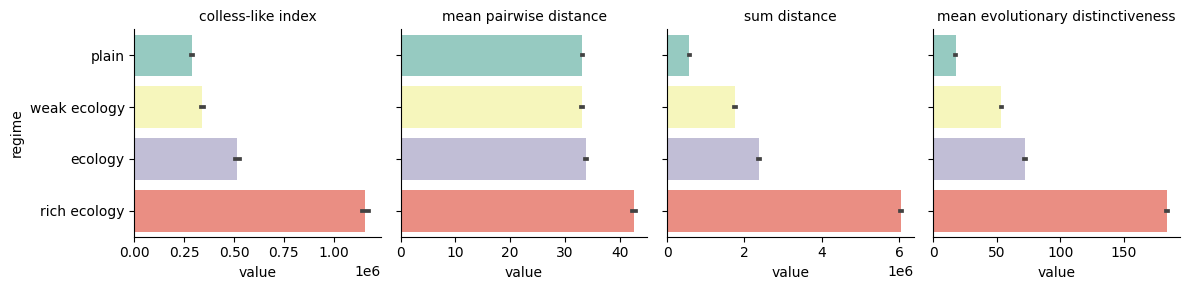

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


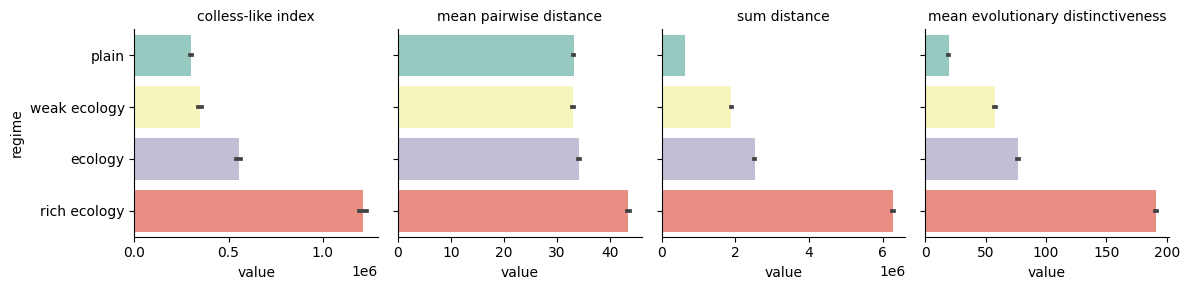

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


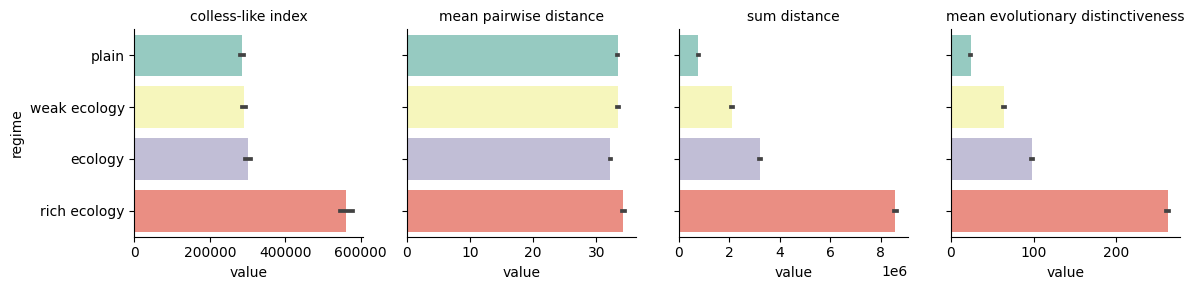

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


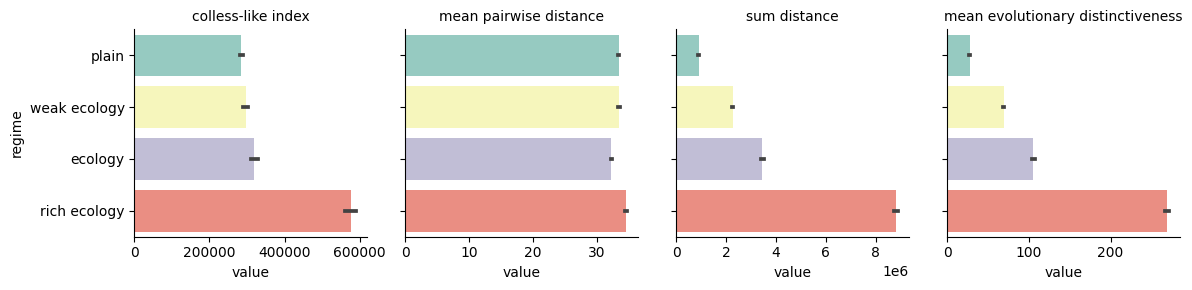

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


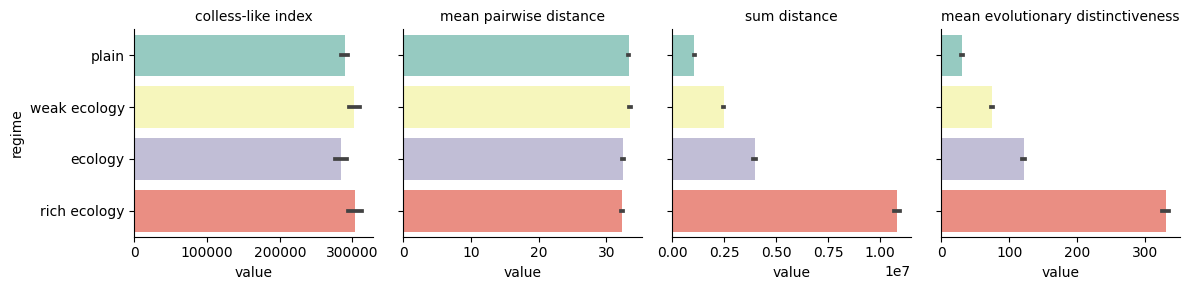

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


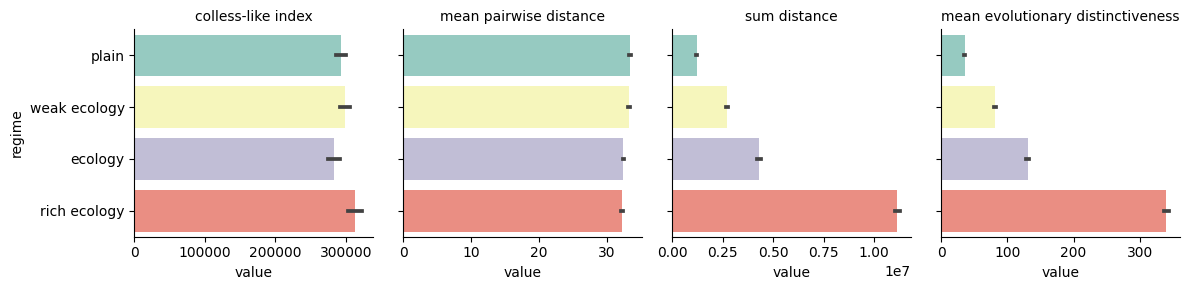

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


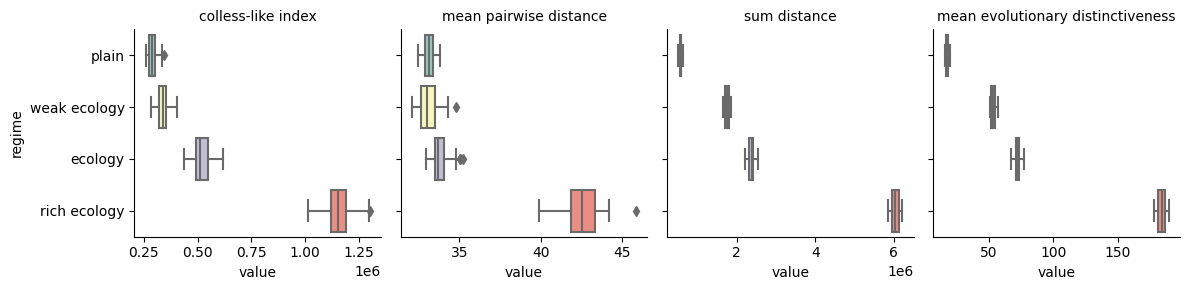

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


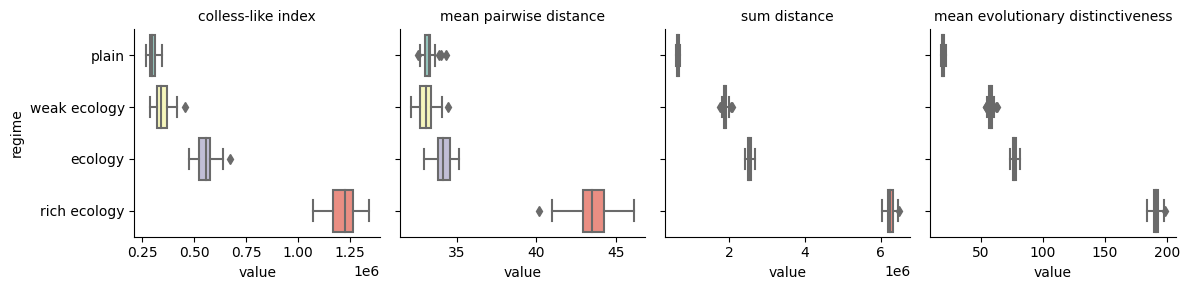

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


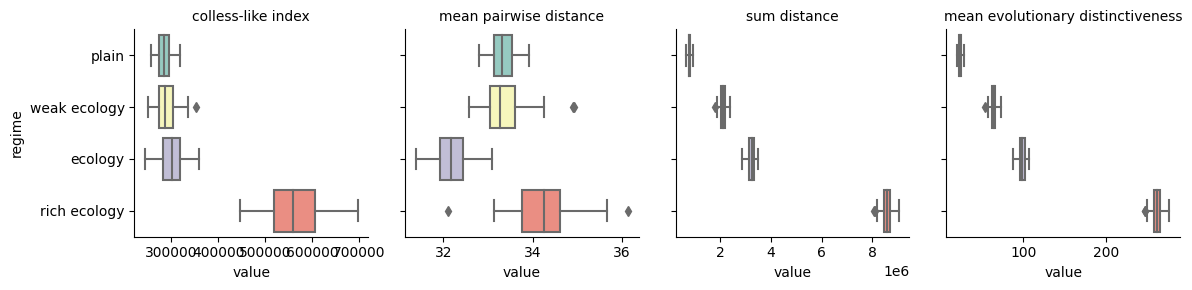

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


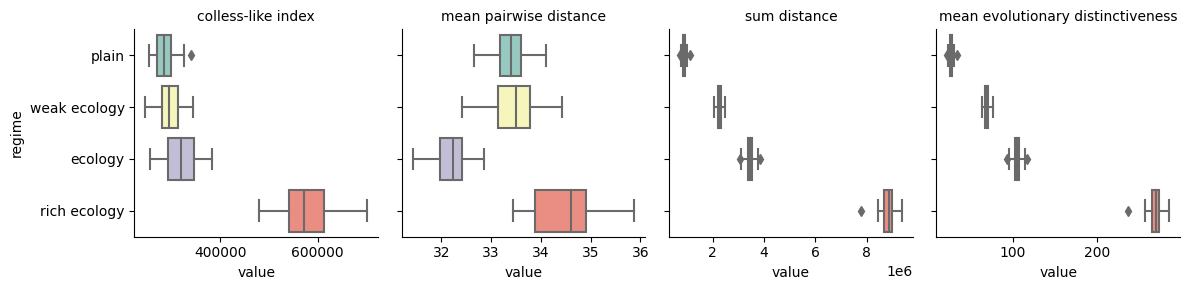

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


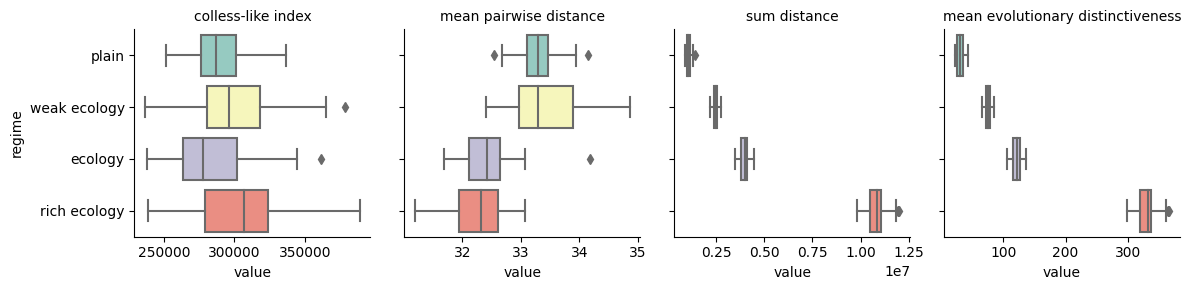

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


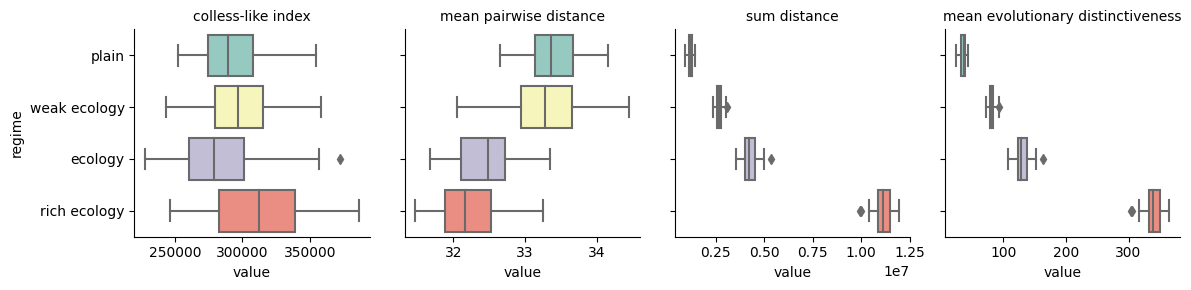

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


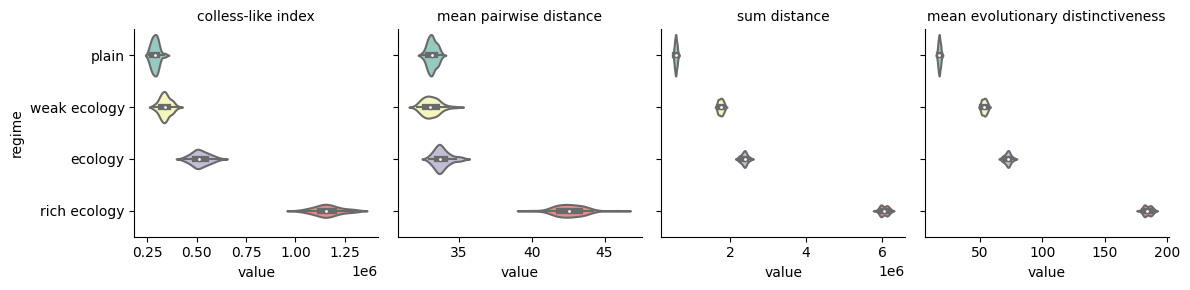

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


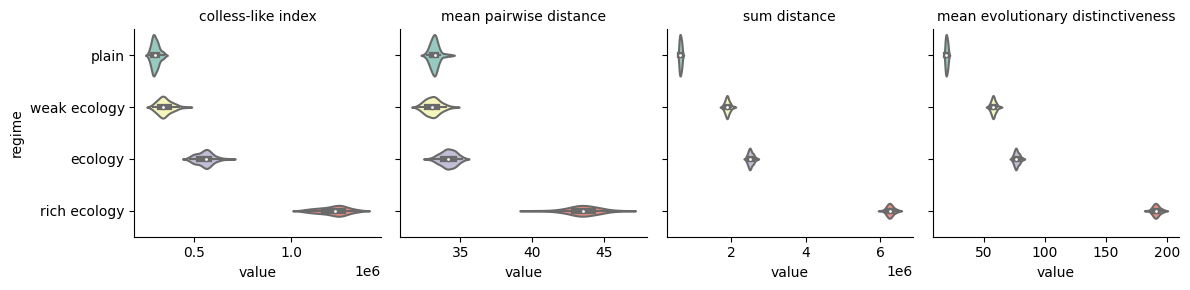

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


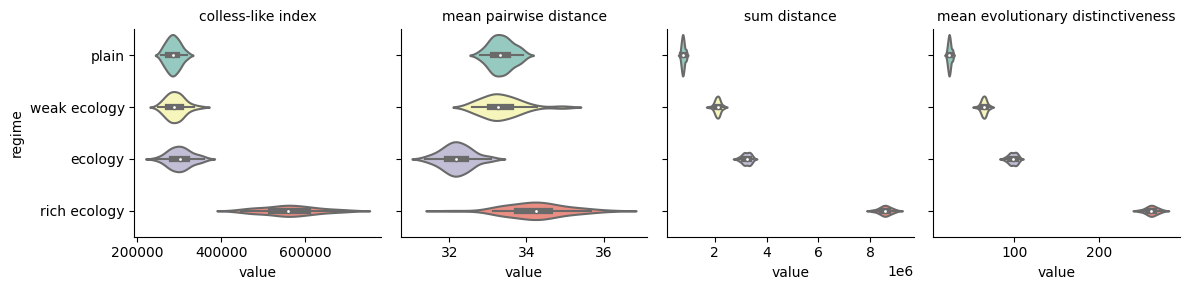

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


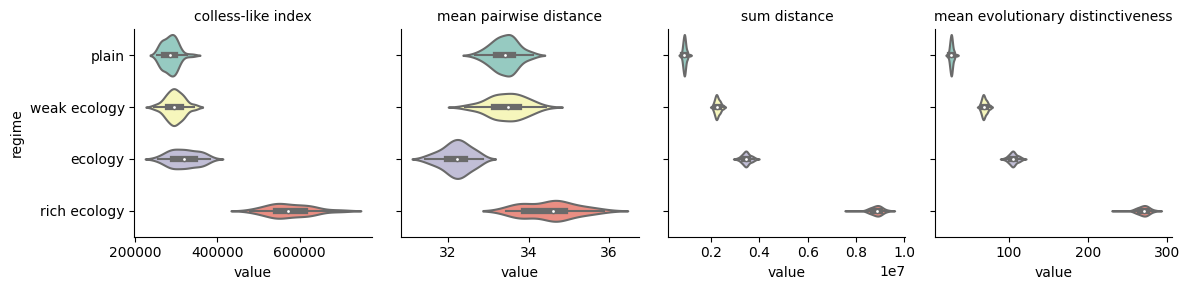

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


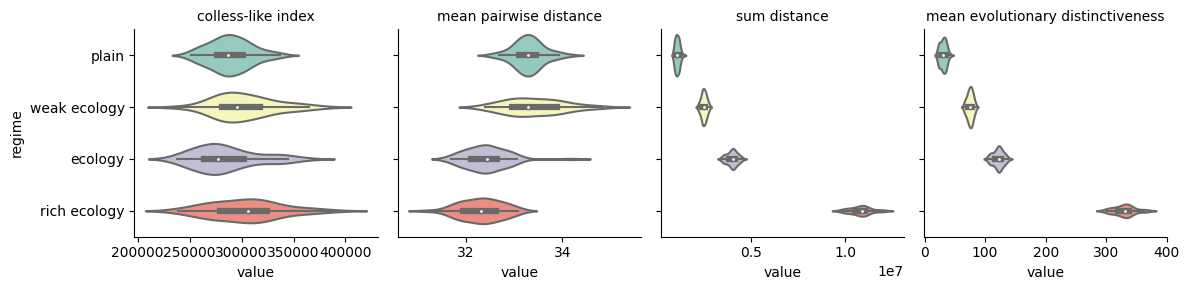

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


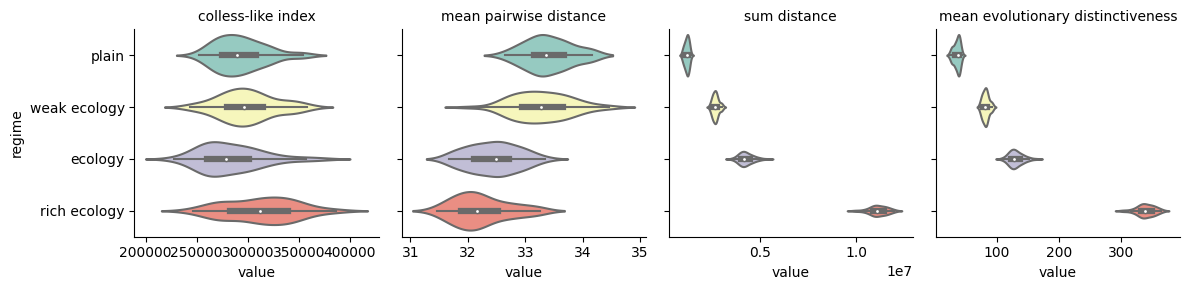

In [19]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            palette=sns.color_palette("Set3", 4),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs={
            **{
                "nuisance": "spatial-structure",
            },
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
        },
    )


teeplots/epoch=0+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


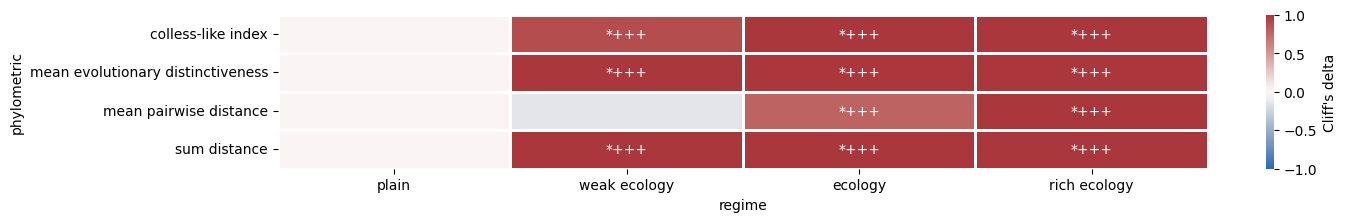

teeplots/epoch=0+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


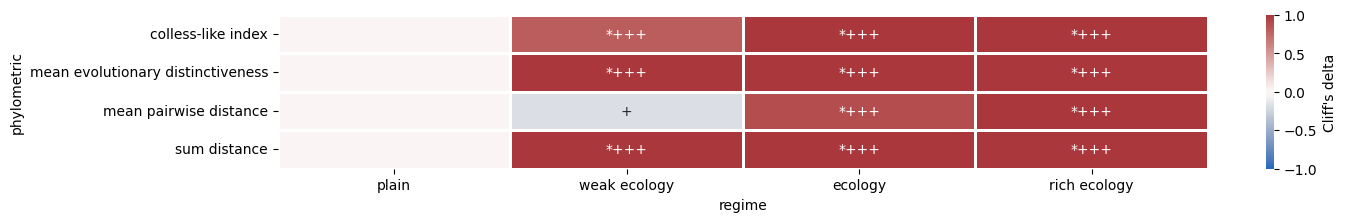

teeplots/epoch=2+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


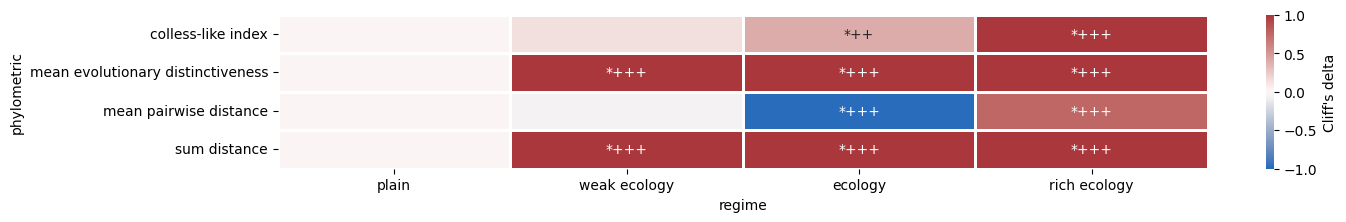

teeplots/epoch=2+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


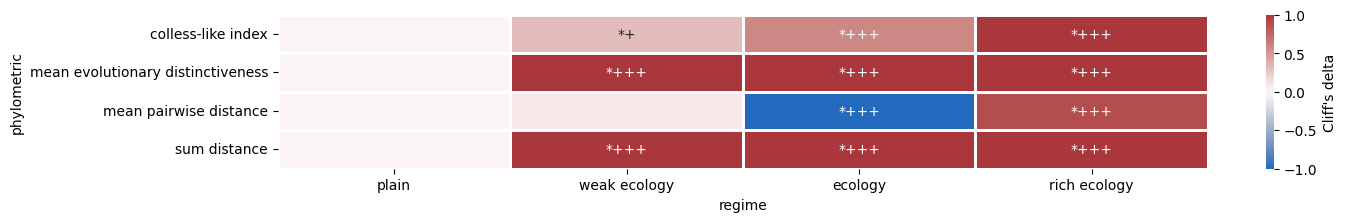

teeplots/epoch=7+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


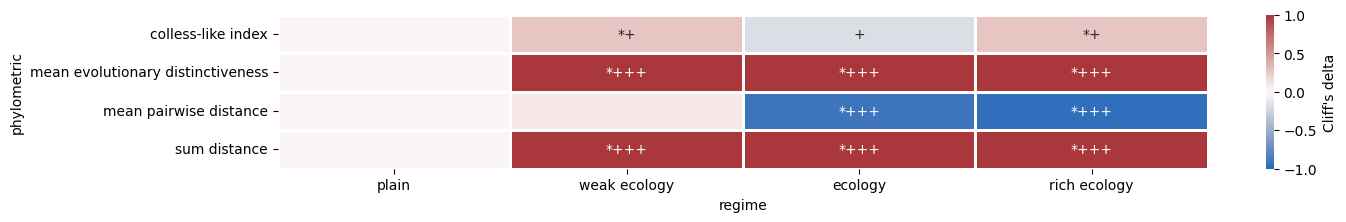

teeplots/epoch=7+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


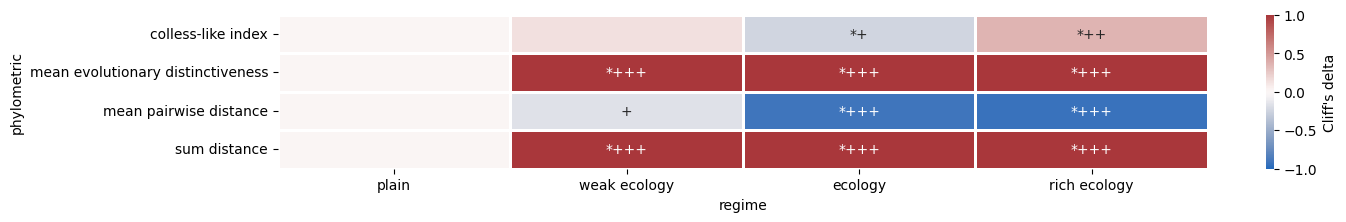

In [20]:
for (group, group_df) in df.groupby(sensitivity_analysis_variables):

    fil = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )

    melted_df = fil.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]

    def calc_cliffs_delta(group) -> float:
        phylometric, regime = group.name
        return -cliffs_delta(
            fil[fil["regime"] == "plain"][phylometric],
            fil[fil["regime"] == regime][phylometric],
        )[0]

    melted_df = melted_df.groupby(["phylometric", "regime"]).apply(
        calc_cliffs_delta,
    ).reset_index(name="value")

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    annot = []
    for metric, row in matrix.iterrows():

        def getvec(regime: str) -> np.array:
            return fil[fil["regime"] == regime][metric].to_numpy()

        annot.append(
            [
                describe_effect(getvec("plain"), getvec(regime))
                for regime in matrix.columns
            ],
        )

    tp.tee(
        sns.heatmap,
        matrix,
        annot=annot,
        fmt="",
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "Cliff's delta"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
            "spatial": "true",
        },
        teeplot_outexclude=["fmt"],
        vmin=-1,
        vmax=1,
    )


# stats: kruskal wallace among regimes


In [21]:
records = []
for phylometric in phylometrics:
    for group, group_df in df[(df["a"] == "collapsed-phylogeny")].groupby(
        sensitivity_analysis_variables,
        as_index=False,
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), min(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-spatial-nuisance-kwallis+ext=.csv",
        index=False,
    )


n  N                        phylometric   statistic             p  epoch  \
0   50  4                 colless-like index  182.463475  2.590889e-39      0   
1   50  4             mean pairwise distance  142.655857  1.011049e-30      0   
2   50  4                       sum distance  186.567164  3.366062e-40      0   
3   50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      0   
4   50  4                 colless-like index  180.139033  8.230783e-39      0   
5   50  4             mean pairwise distance  155.228669  1.962095e-33      0   
6   50  4                       sum distance  186.567164  3.366062e-40      0   
7   50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      0   
8   50  4                 colless-like index  118.649851  1.507305e-25      2   
9   50  4             mean pairwise distance  135.366496  3.770580e-29      2   
10  50  4                       sum distance  186.567164  3.366062e-40      2   
11  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      2   
12  50  4                 colless-like index  128.329946  1.238671e-27      2   
13  50  4             mean pairwise distance  151.095881  1.528830e-32      2   
14  50  4                       sum distance  186.567164  3.366062e-40      2   
15  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      2   
16  50  4                 colless-like index   15.898098  1.189858e-03      7   
17  50  4             mean pairwise distance  121.377469  3.897279e-26      7   
18  50  4                       sum distance  186.567164  3.366062e-40      7   
19  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      7   
20  50  4                 colless-like index   22.718615  4.622060e-05      7   
21  50  4             mean pairwise distance  118.175964  1.906556e-25      7   
22  50  4                       sum distance  186.567164  3.366062e-40      7   
23  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      7   

                    mut_distn  
0       np.random.exponential  
1       np.random.exponential  
2       np.random.exponential  
3       np.random.exponential  
4   np.random.standard_normal  
5   np.random.standard_normal  
6   np.random.standard_normal  
7   np.random.standard_normal  
8       np.random.exponential  
9       np.random.exponential  
10      np.random.exponential  
11      np.random.exponential  
12  np.random.standard_normal  
13  np.random.standard_normal  
14  np.random.standard_normal  
15  np.random.standard_normal  
16      np.random.exponential  
17      np.random.exponential  
18      np.random.exponential  
19      np.random.exponential  
20  np.random.standard_normal  
21  np.random.standard_normal  
22  np.random.standard_normal  
23  np.random.standard_normal

In [22]:
records = []
for phylometric in phylometrics:
    for group, group_df in df[(df["a"] == "collapsed-phylogeny")].groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                *zip(
                    *zip(
                        group_df[group_df["regime"] == regime1][phylometric],
                        group_df[group_df["regime"] == regime2][phylometric],
                    )
                ),
            ), min(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-spatial-nuisance-wilcox+ext=.csv",
        index=False,
    )


regime1       regime2   n                        phylometric  \
0         ecology         plain  50                 colless-like index   
1         ecology         plain  50             mean pairwise distance   
2         ecology         plain  50                       sum distance   
3         ecology         plain  50  mean evolutionary distinctiveness   
4         ecology  rich ecology  50                 colless-like index   
5         ecology  rich ecology  50             mean pairwise distance   
6         ecology  rich ecology  50                       sum distance   
7         ecology  rich ecology  50  mean evolutionary distinctiveness   
8         ecology  weak ecology  50                 colless-like index   
9         ecology  weak ecology  50             mean pairwise distance   
10        ecology  weak ecology  50                       sum distance   
11        ecology  weak ecology  50  mean evolutionary distinctiveness   
12          plain  rich ecology  50                 colless-like index   
13          plain  rich ecology  50             mean pairwise distance   
14          plain  rich ecology  50                       sum distance   
15          plain  rich ecology  50  mean evolutionary distinctiveness   
16   weak ecology         plain  50                 colless-like index   
17   weak ecology         plain  50             mean pairwise distance   
18   weak ecology         plain  50                       sum distance   
19   weak ecology         plain  50  mean evolutionary distinctiveness   
20   weak ecology  rich ecology  50                 colless-like index   
21   weak ecology  rich ecology  50             mean pairwise distance   
22   weak ecology  rich ecology  50                       sum distance   
23   weak ecology  rich ecology  50  mean evolutionary distinctiveness   
24          plain       ecology  50                 colless-like index   
25          plain       ecology  50             mean pairwise distance   
26          plain       ecology  50                       sum distance   
27          plain       ecology  50  mean evolutionary distinctiveness   
28          plain  rich ecology  50                 colless-like index   
29          plain  rich ecology  50             mean pairwise distance   
30          plain  rich ecology  50                       sum distance   
31          plain  rich ecology  50  mean evolutionary distinctiveness   
32          plain  weak ecology  50                 colless-like index   
33          plain  weak ecology  50             mean pairwise distance   
34          plain  weak ecology  50                       sum distance   
35          plain  weak ecology  50  mean evolutionary distinctiveness   
36   rich ecology       ecology  50                 colless-like index   
37   rich ecology       ecology  50             mean pairwise distance   
38   rich ecology       ecology  50                       sum distance   
39   rich ecology       ecology  50  mean evolutionary distinctiveness   
40   rich ecology  weak ecology  50                 colless-like index   
41   rich ecology  weak ecology  50             mean pairwise distance   
42   rich ecology  weak ecology  50                       sum distance   
43   rich ecology  weak ecology  50  mean evolutionary distinctiveness   
44   weak ecology       ecology  50                 colless-like index   
45   weak ecology       ecology  50             mean pairwise distance   
46   weak ecology       ecology  50                       sum distance   
47   weak ecology       ecology  50  mean evolutionary distinctiveness   
48        ecology  weak ecology  50                 colless-like index   
49        ecology  weak ecology  50             mean pairwise distance   
50        ecology  weak ecology  50                       sum distance   
51        ecology  weak ecology  50  mean evolutionary distinctiveness   
52          plain       ecology  50                 colless-like index   
53          pl

# reconstructed phylogenetic data


In [23]:
df["quality"] = df.apply(
    lambda row: {
        ("reconstructed-tree", 3.0): "33% resolution",
        ("reconstructed-tree", 10.0): "10% resolution",
        ("reconstructed-tree", 30.0): "3% resolution",
        ("reconstructed-tree", 100.0): "1% resolution",
        ("collapsed-phylogeny", 0): "perfect resolution",
    }.get(
        tuple(row[["a", "resolution"]].fillna(0)),
        np.nan,  # default
    ),
    axis="columns",
)
df["quality"].unique()


array(['perfect resolution', '10% resolution', '1% resolution',
       '3% resolution', '33% resolution'], dtype=object)

In [24]:
melted_df = df.melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime", "a", "quality"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


num_niches  resolution  epoch                  mut_distn        regime  \
0               4         NaN      7  np.random.standard_normal  weak ecology   
1               4         NaN      7  np.random.standard_normal  weak ecology   
2               4         NaN      7  np.random.standard_normal  weak ecology   
3               4         NaN      7  np.random.standard_normal  weak ecology   
4               4         NaN      7  np.random.standard_normal  weak ecology   
...           ...         ...    ...                        ...           ...   
23995           8         3.0      7      np.random.exponential  rich ecology   
23996           8        30.0      7      np.random.exponential  rich ecology   
23997           8       100.0      7      np.random.exponential  rich ecology   
23998           8        10.0      7      np.random.exponential  rich ecology   
23999           8        30.0      7      np.random.exponential  rich ecology   

                         a             quality  \
0      collapsed-phylogeny  perfect resolution   
1      collapsed-phylogeny  perfect resolution   
2      collapsed-phylogeny  perfect resolution   
3      collapsed-phylogeny  perfect resolution   
4      collapsed-phylogeny  perfect resolution   
...                    ...                 ...   
23995   reconstructed-tree      33% resolution   
23996   reconstructed-tree       3% resolution   
23997   reconstructed-tree       1% resolution   
23998   reconstructed-tree      10% resolution   
23999   reconstructed-tree       3% resolution   

                                variable          value  \
0                     colless-like index  315335.603640   
1                     colless-like index  288402.553239   
2                     colless-like index  296106.640553   
3                     colless-like index  275903.025586   
4                     colless-like index  306209.085898   
...                                  ...            ...   
23995  mean evolutionary distinctiveness     313.221619   
23996  mean evolutionary distinctiveness     336.758774   
23997  mean evolutionary distinctiveness     309.332581   
23998  mean evolutionary distinctiveness     305.019302   
23999  mean evolutionary distinctiveness     330.335556   

                             phylometric  
0                     colless-like index  
1                     colless-like index  
2                     colless-like index  
3                     colless-like index  
4                     colless-like index  
...                                  ...  
23995  mean evolutionary distinctiveness  
23996  mean evolutionary distinctiveness  
23997  mean evolutionary distinctiveness  
23998  mean evolutionary distinctiveness  
23999  mean evolutionary distinctiveness  

[24000 rows x 10 columns]

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


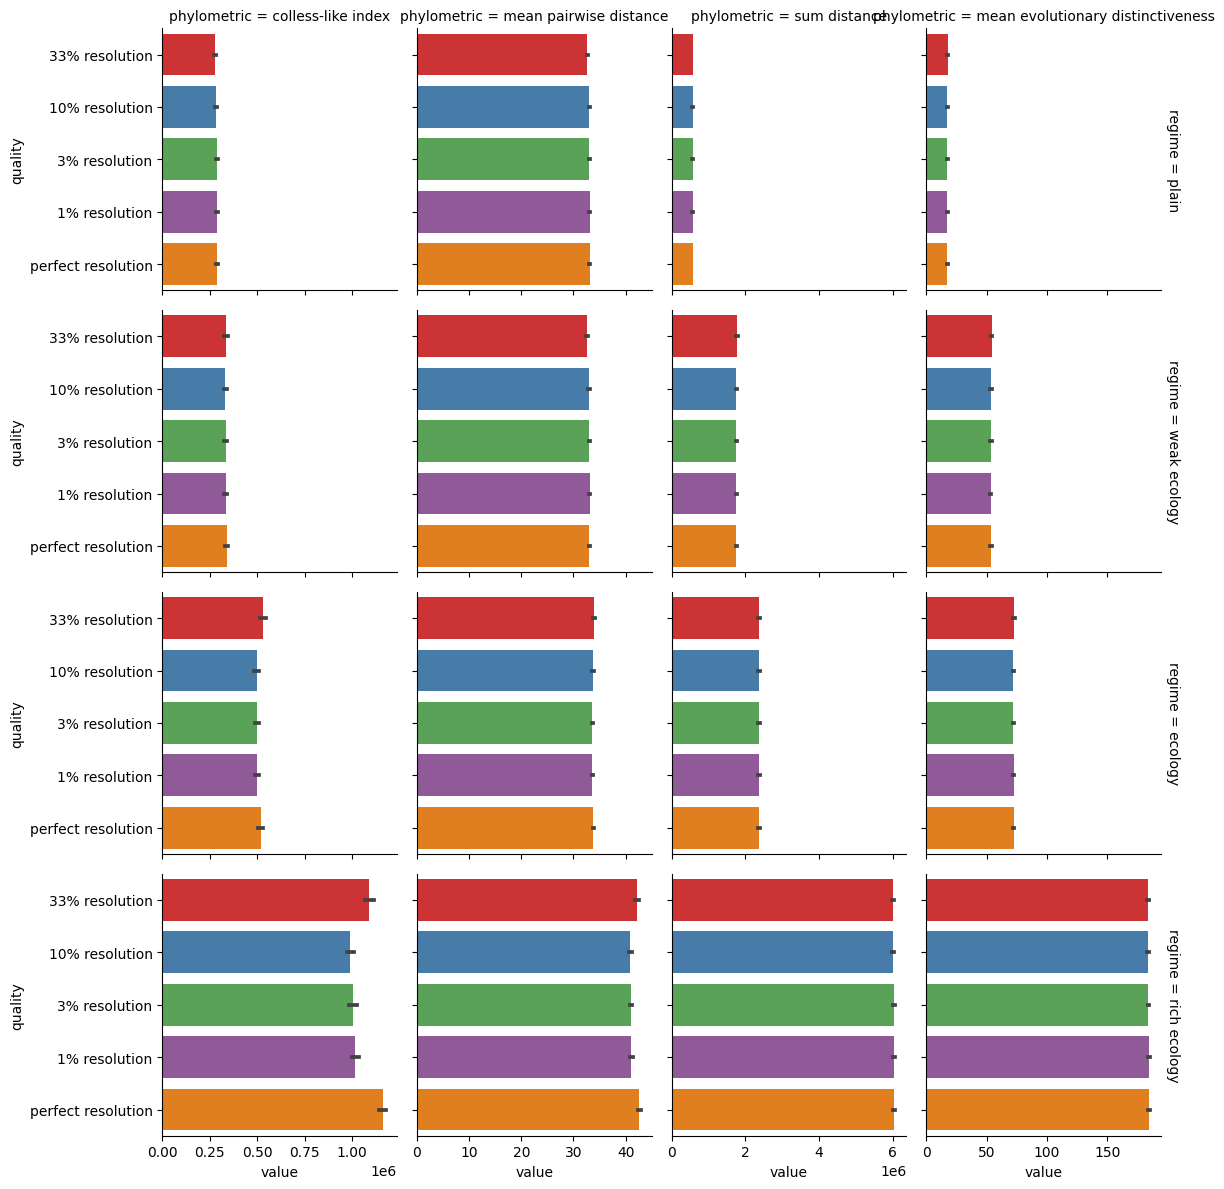

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


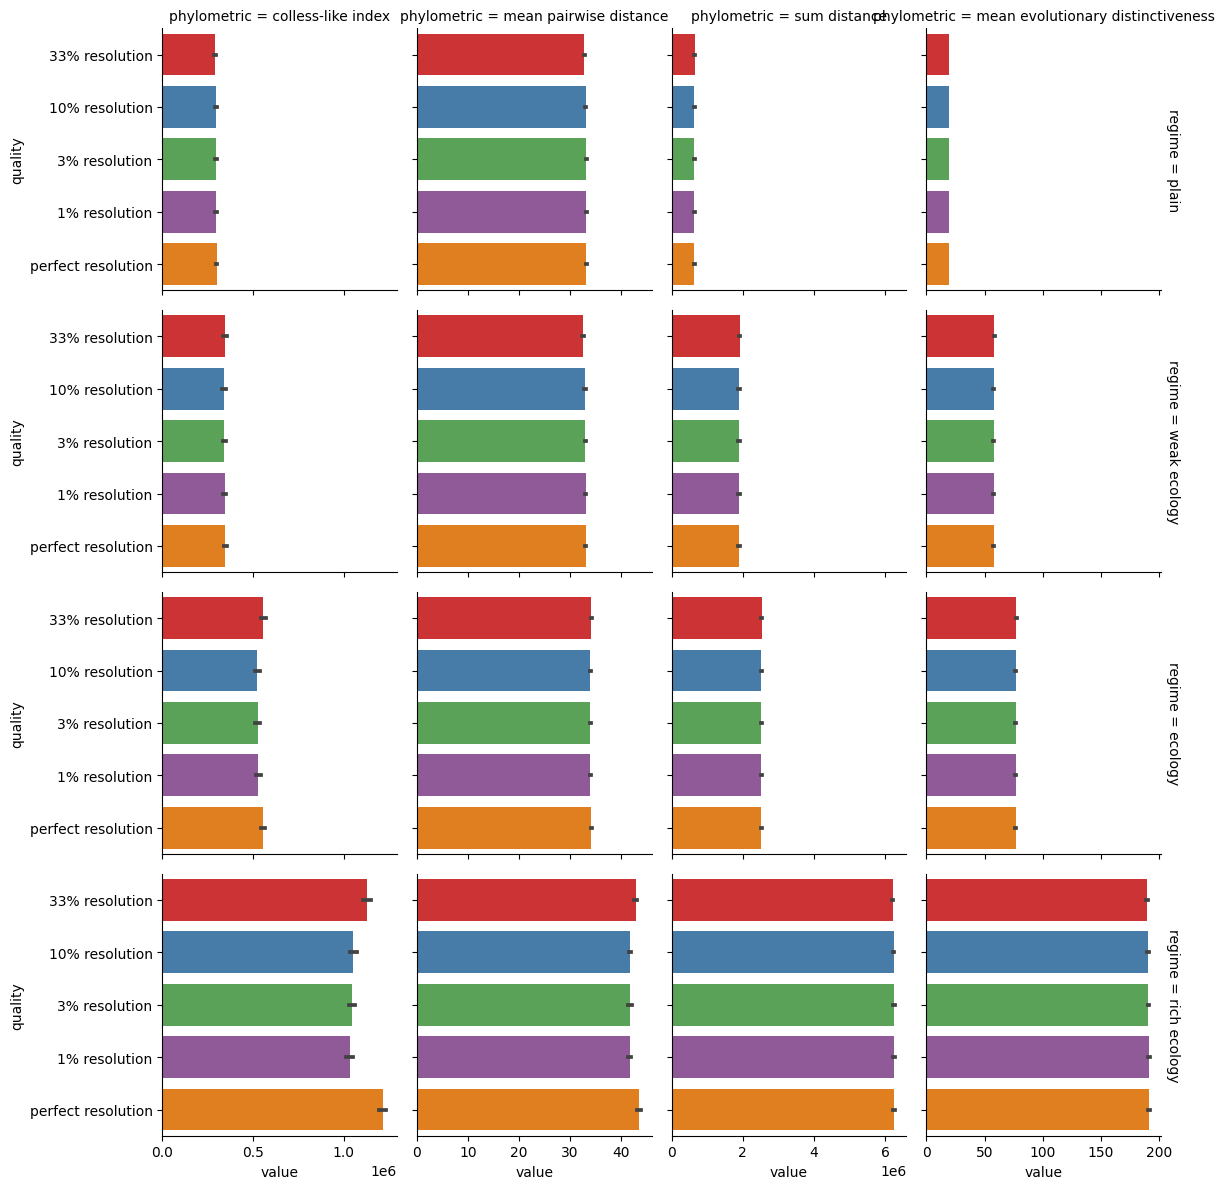

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


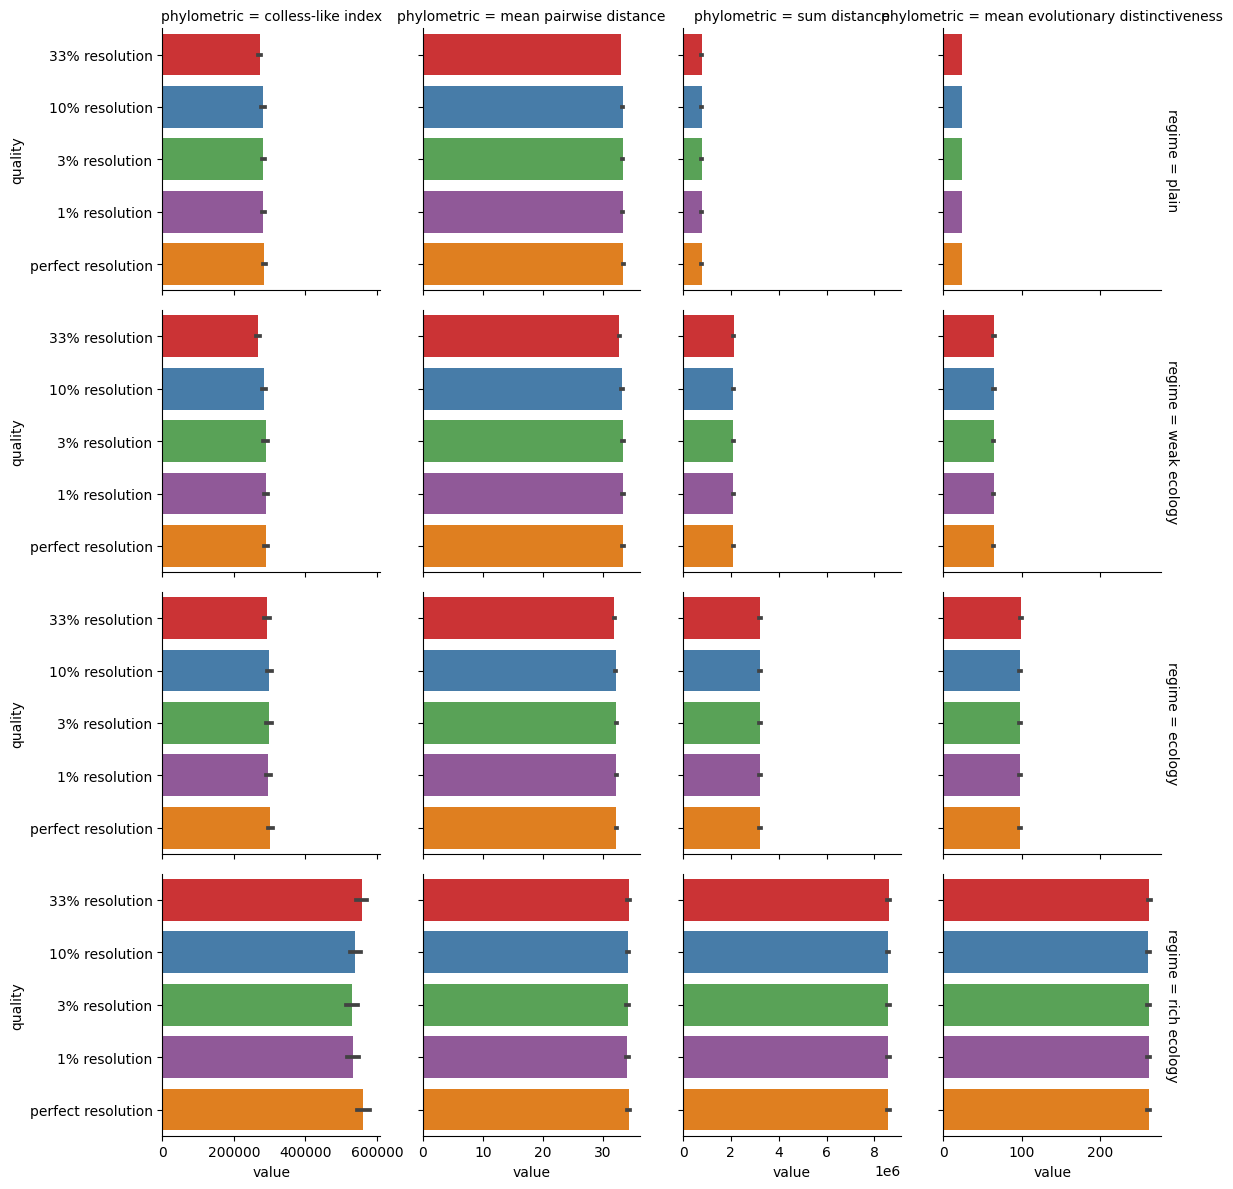

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


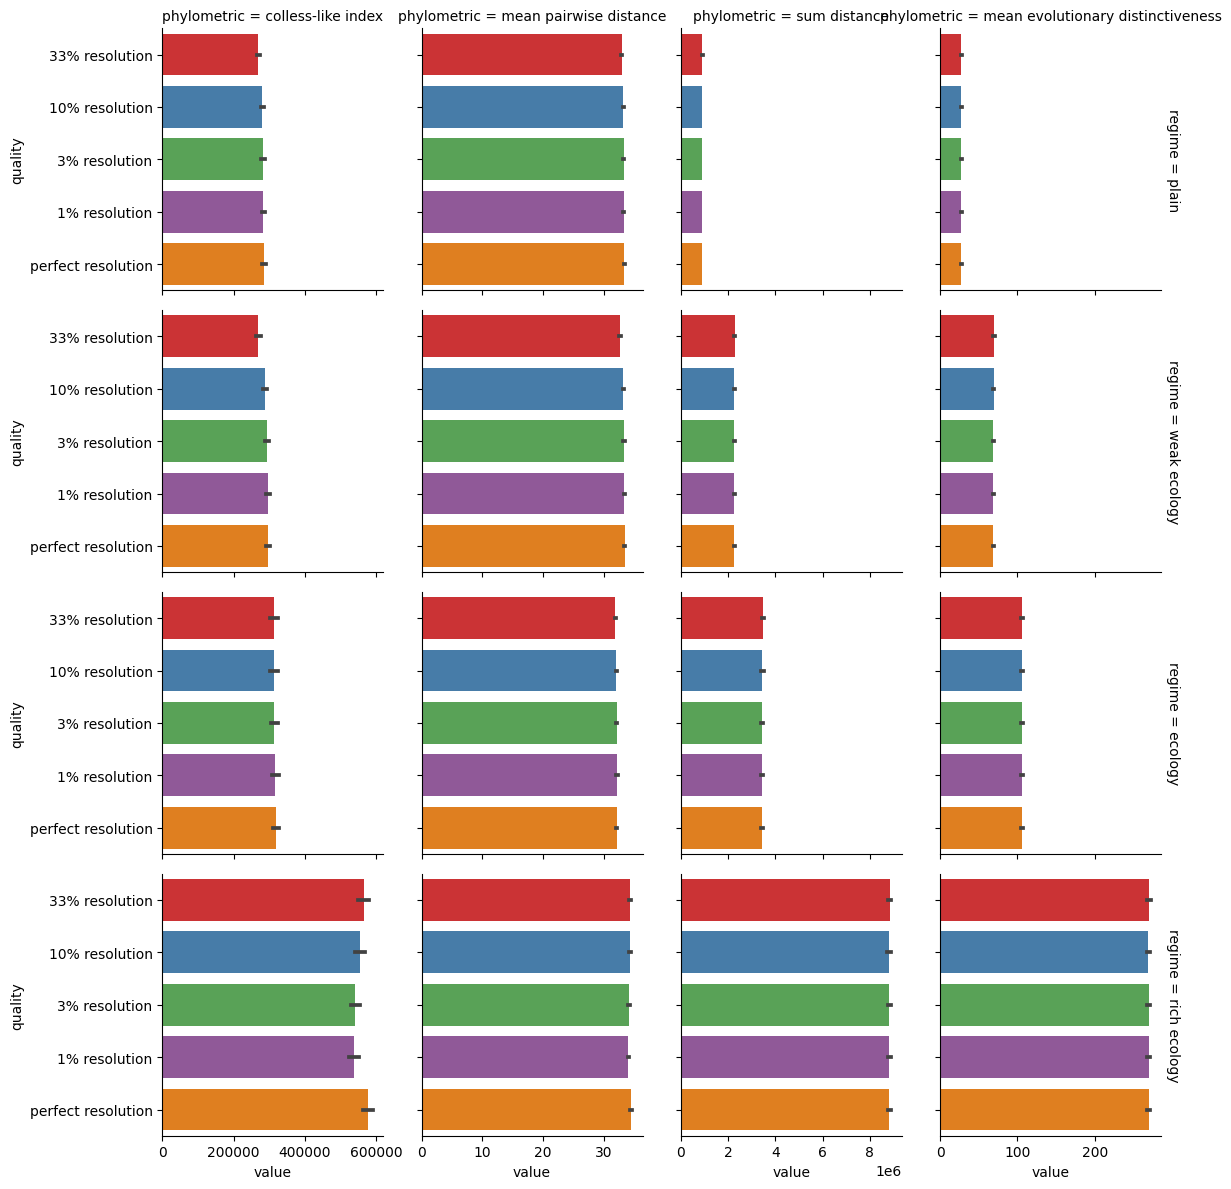

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


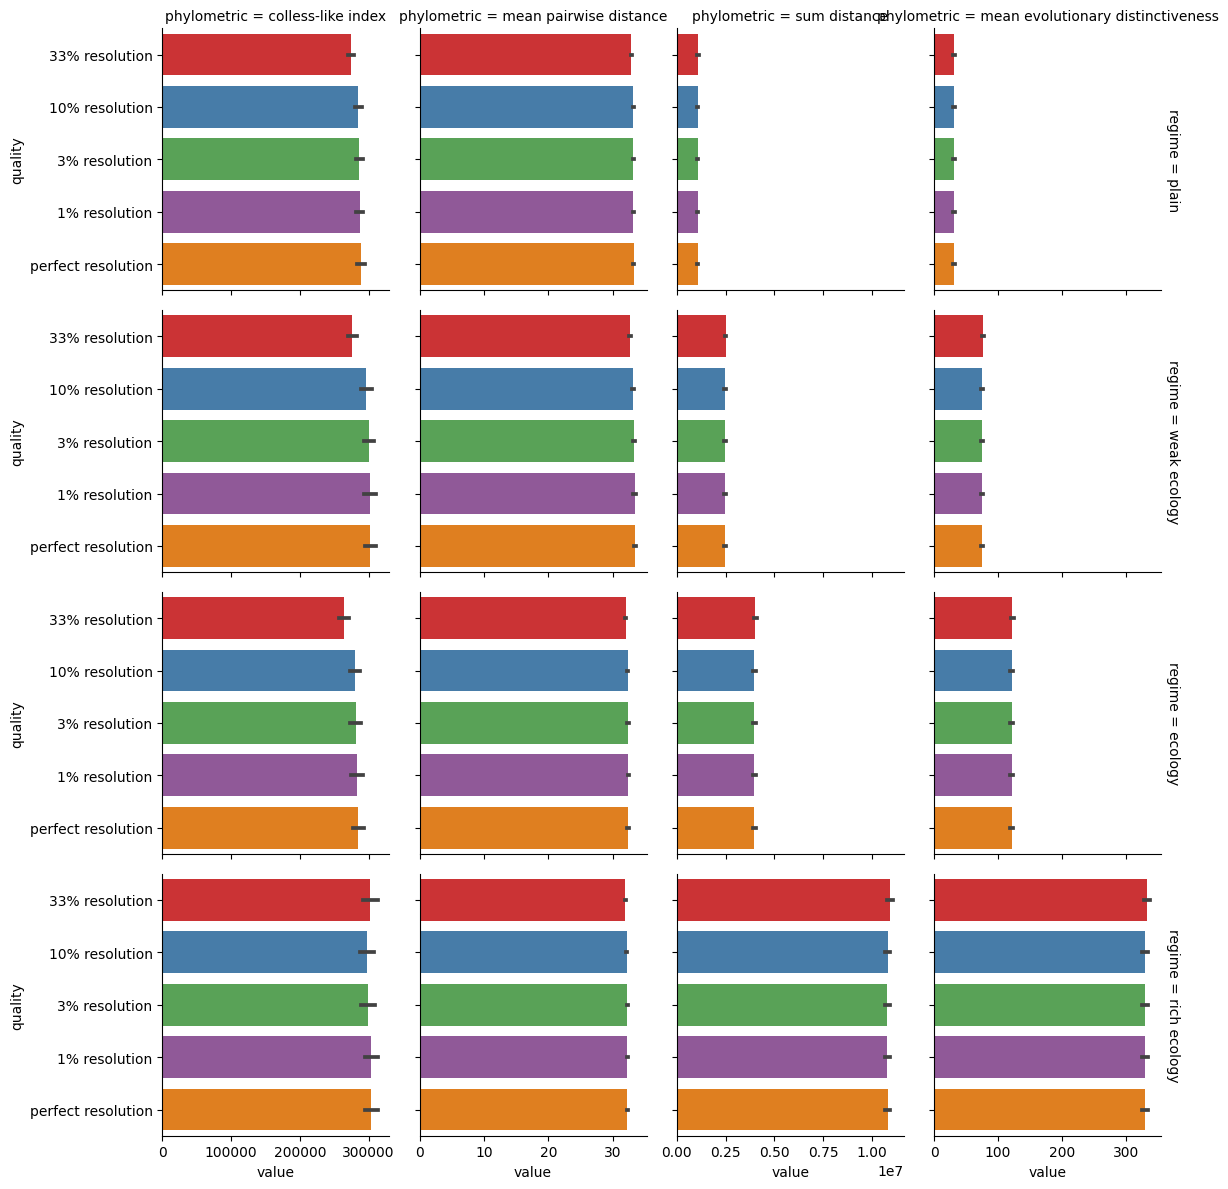

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


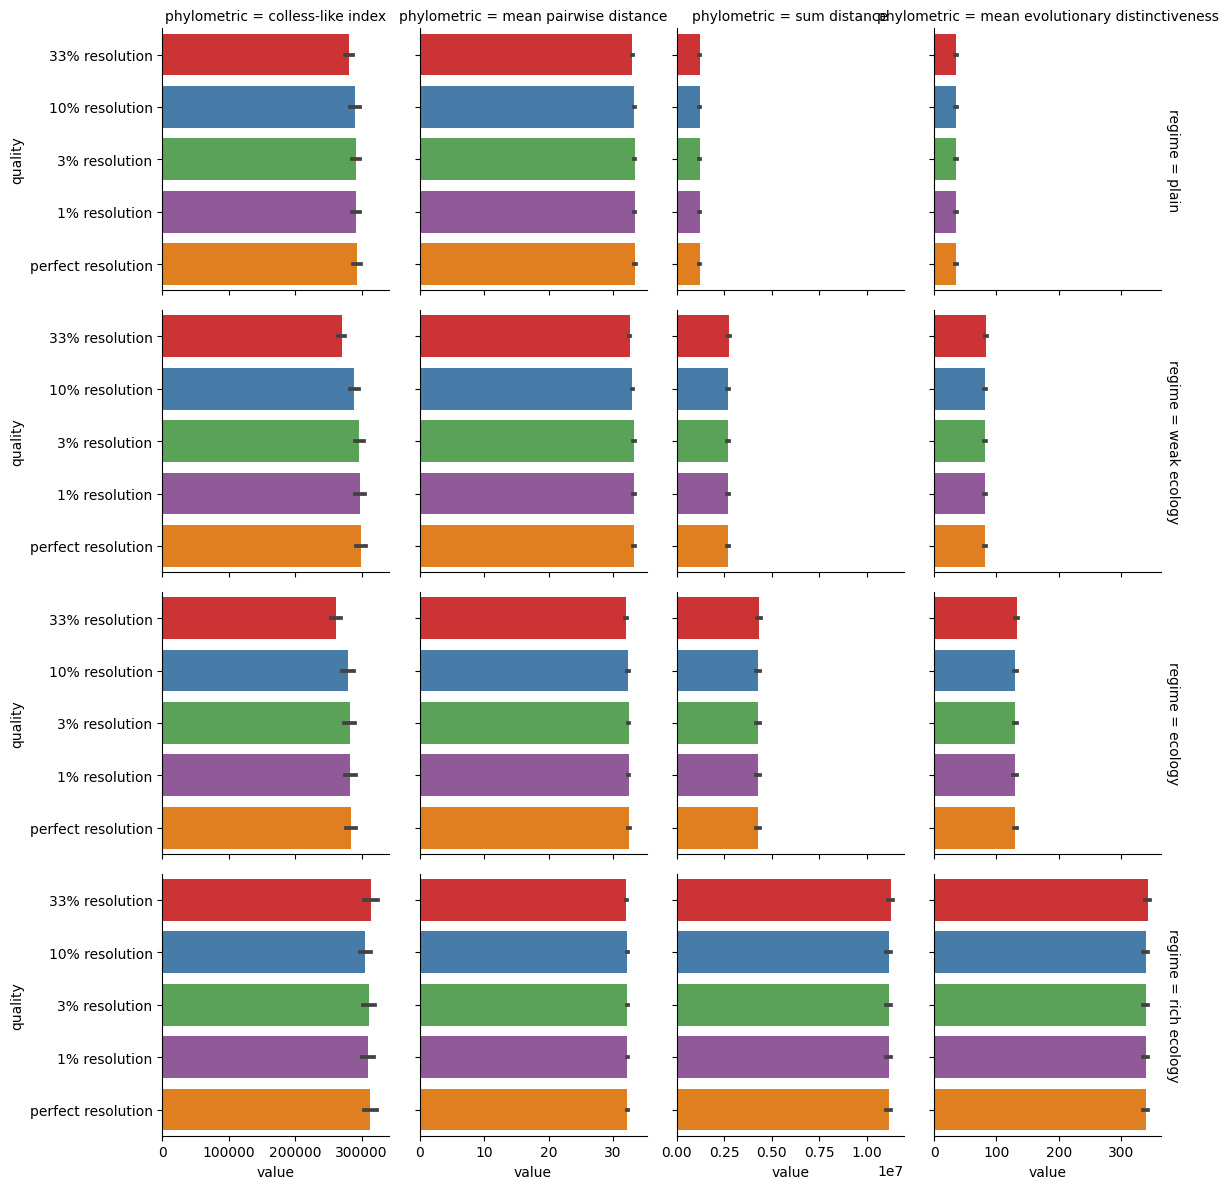

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


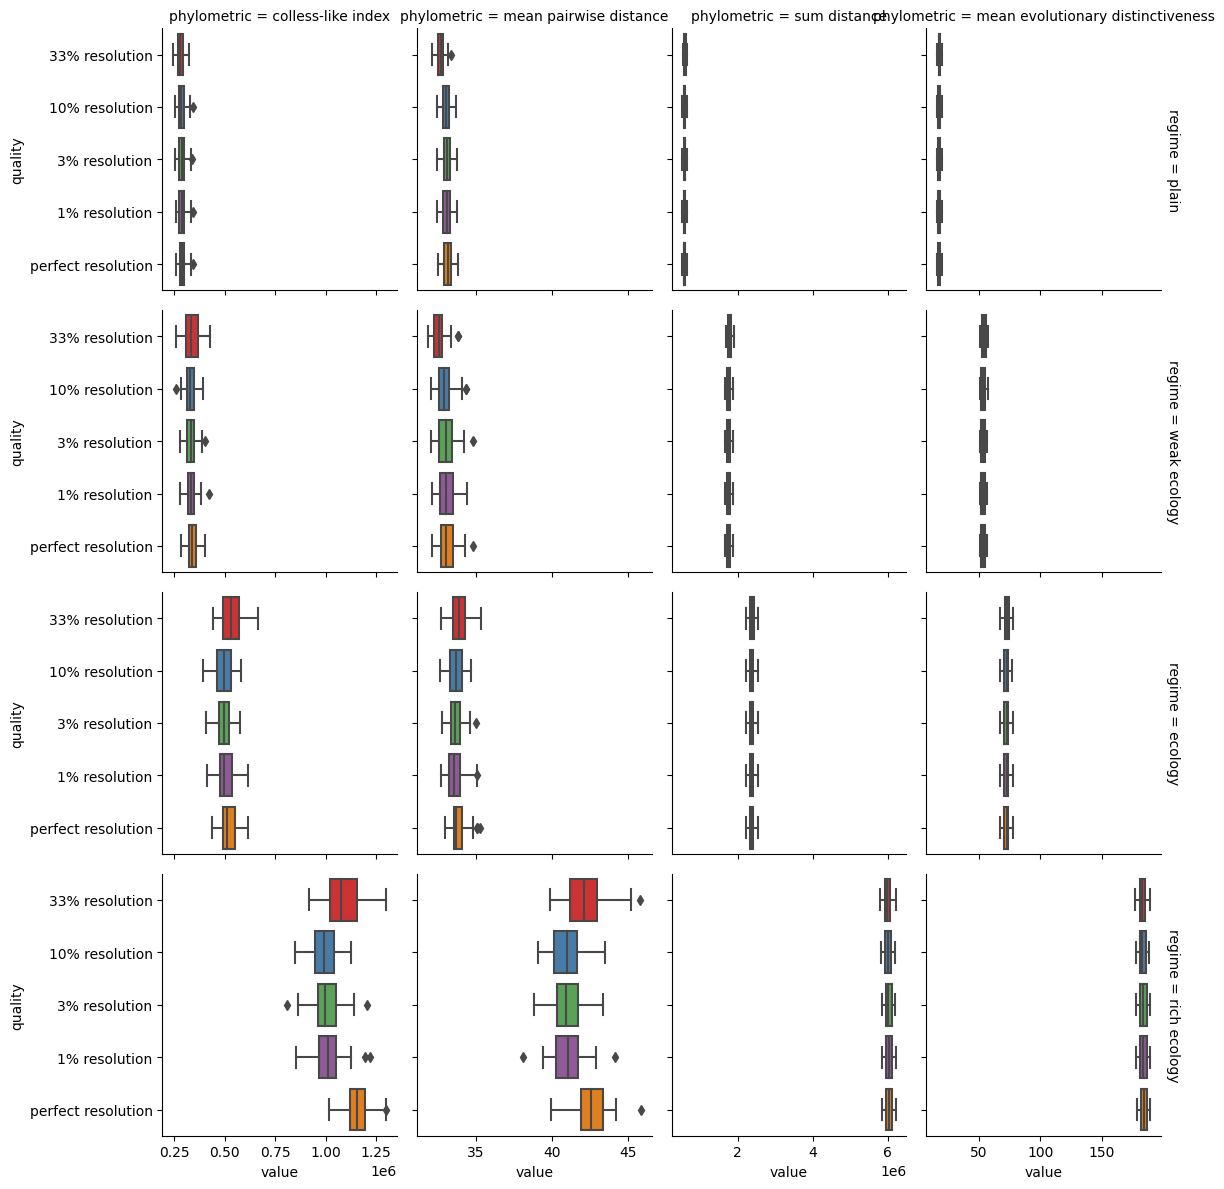

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


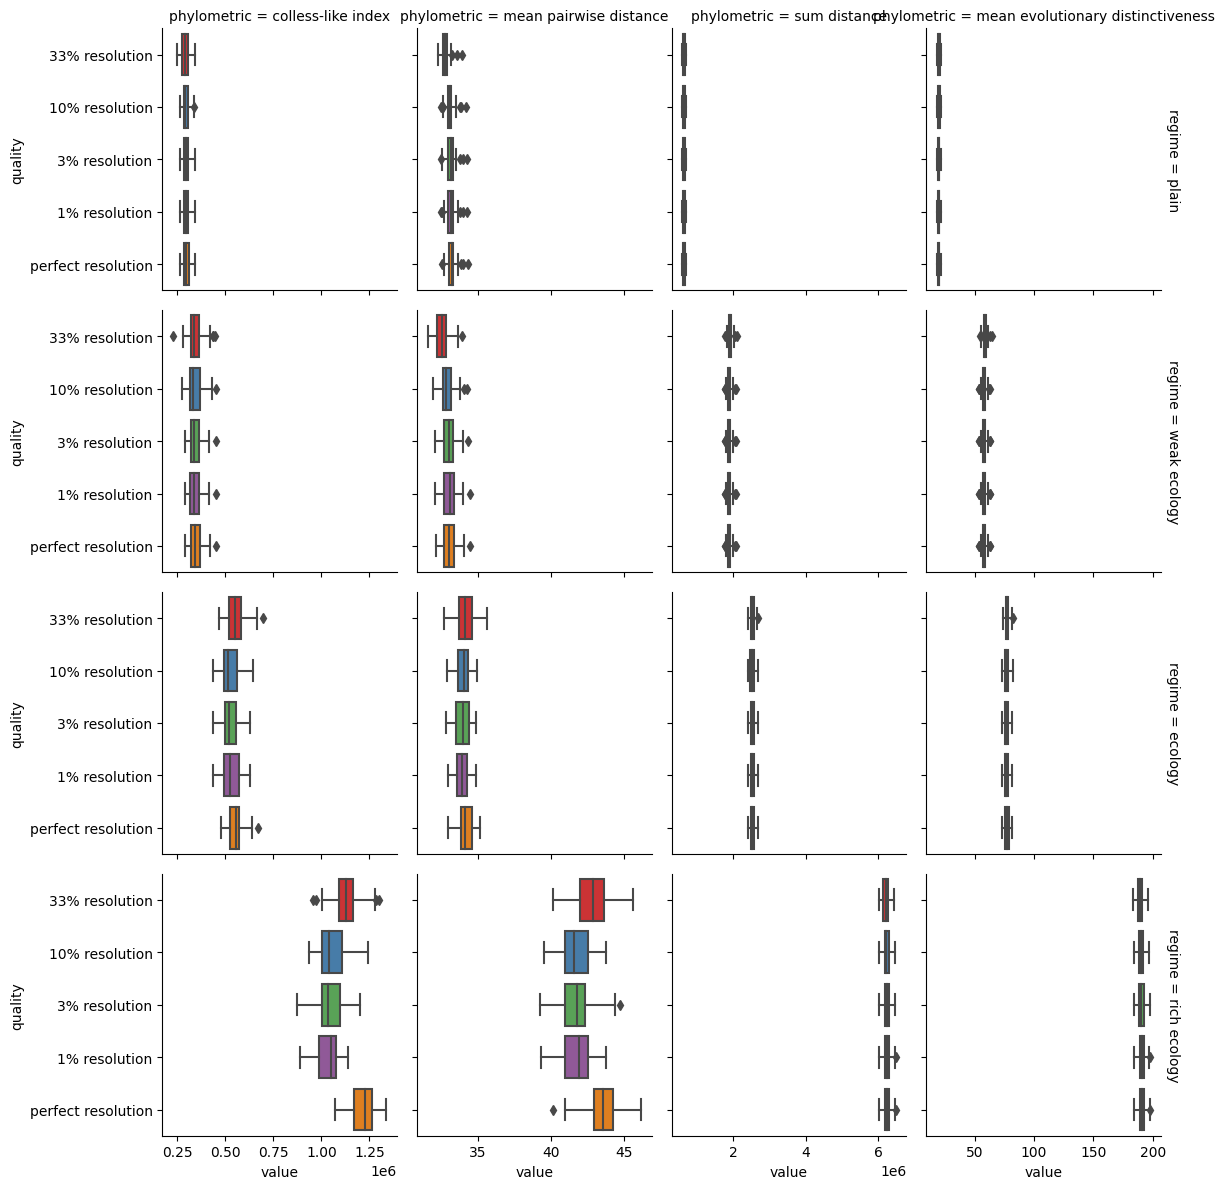

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


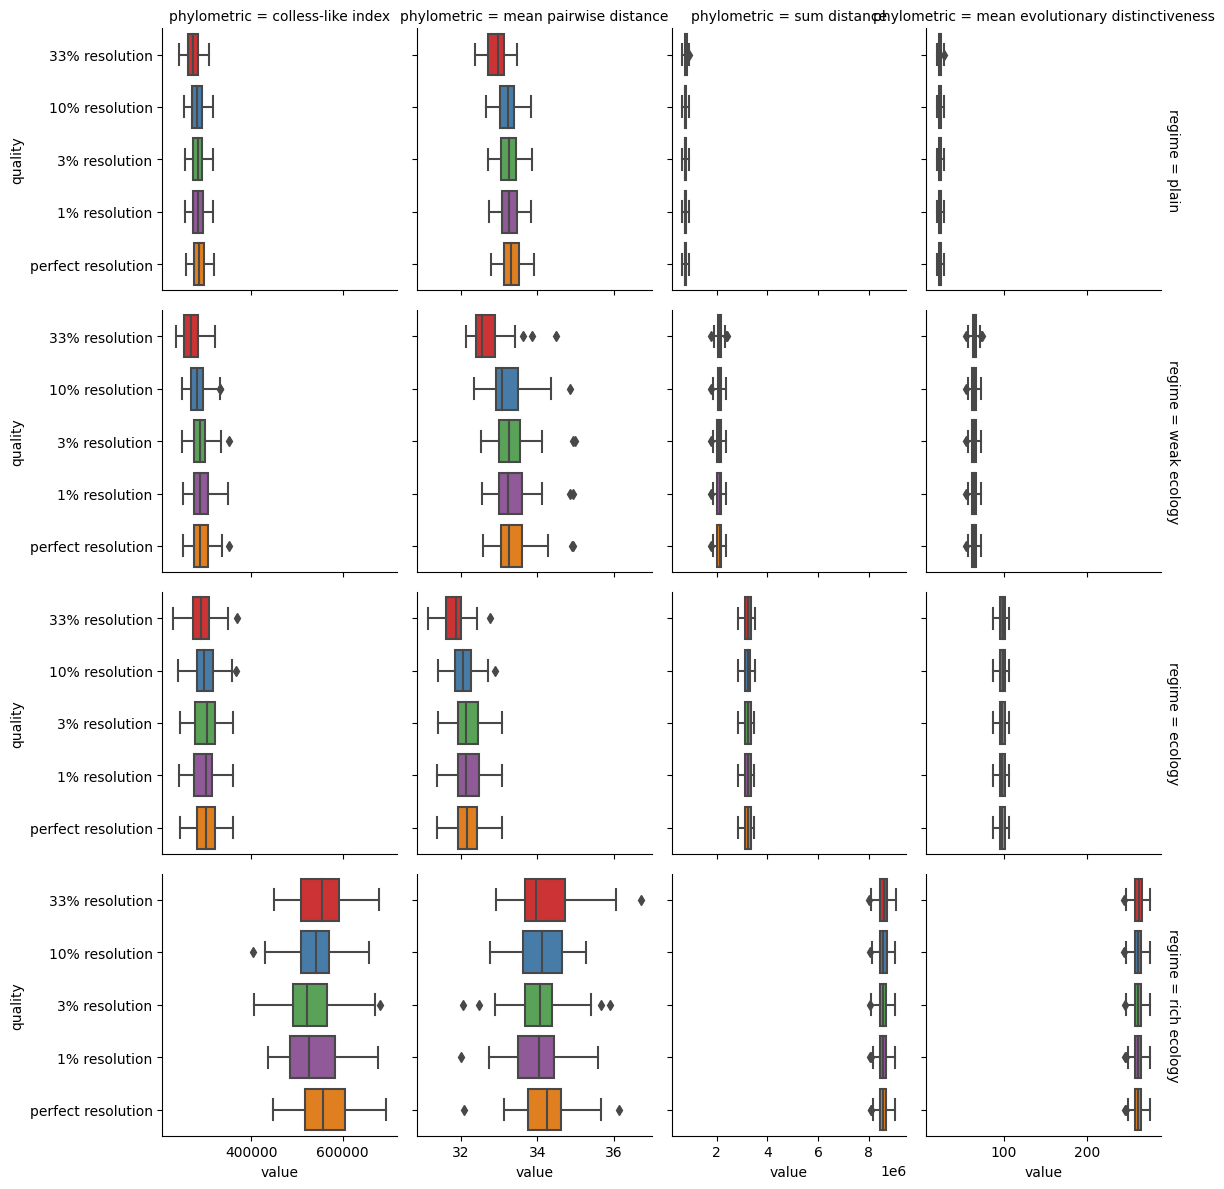

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


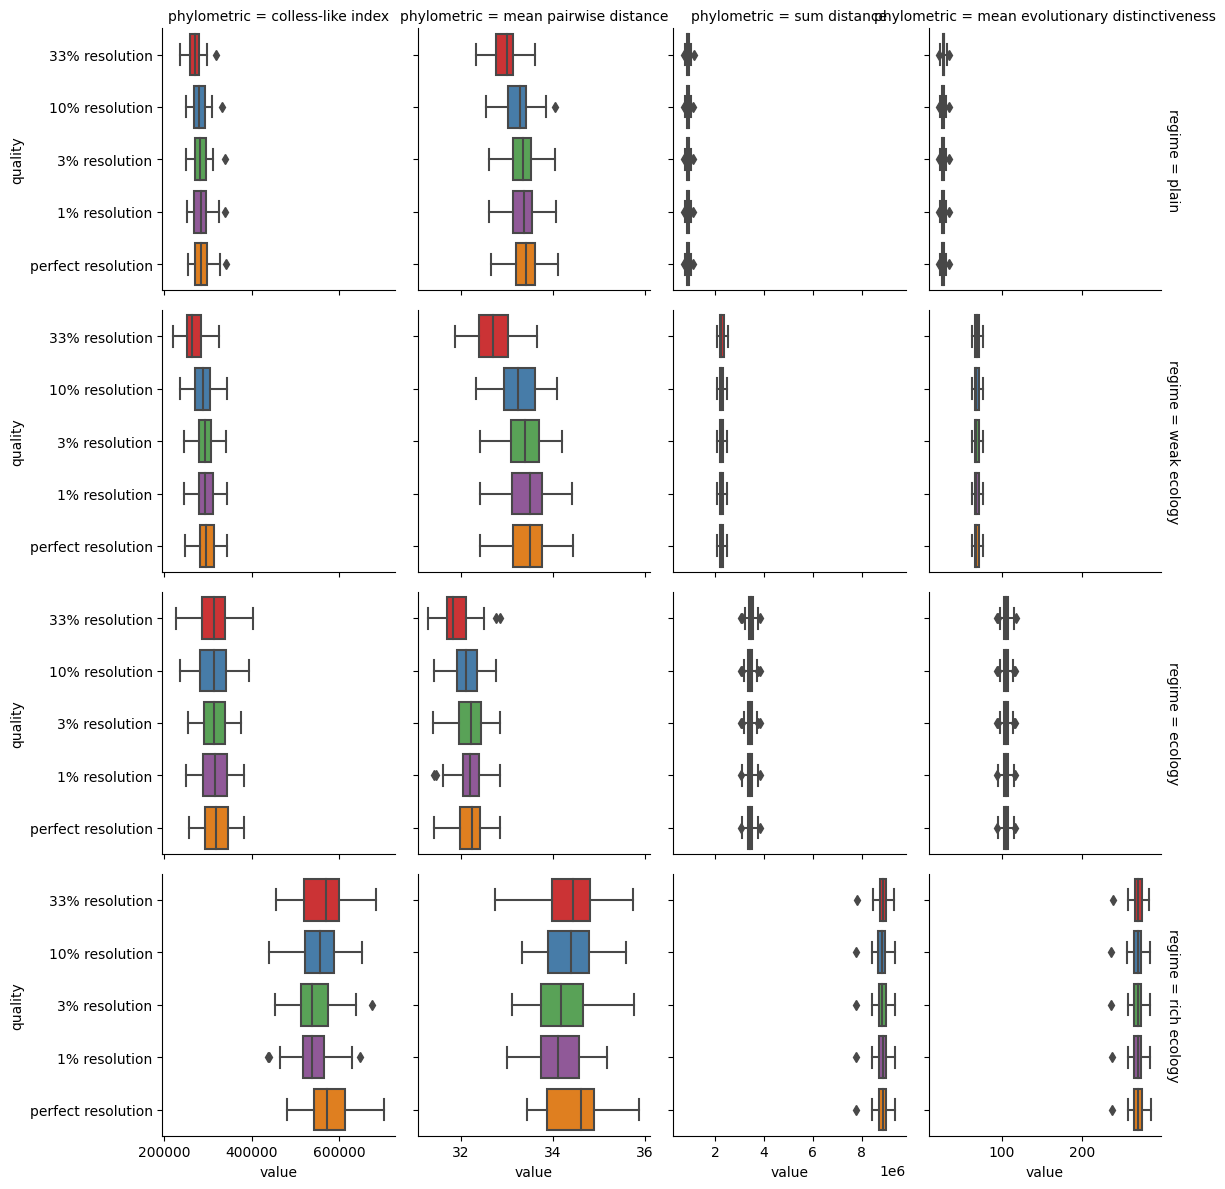

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


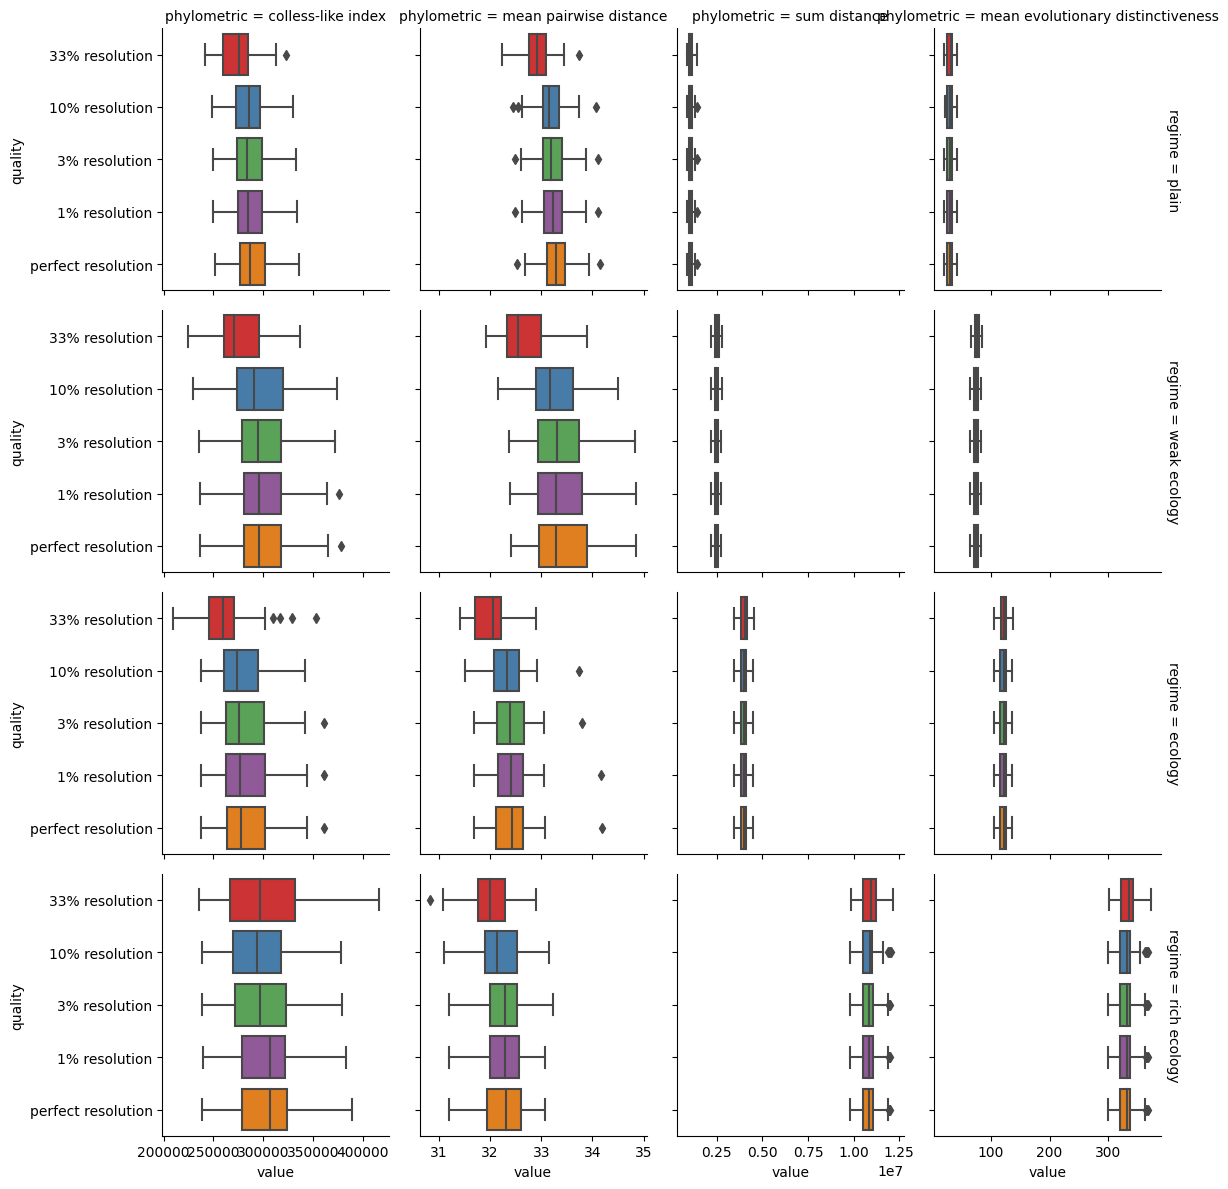

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


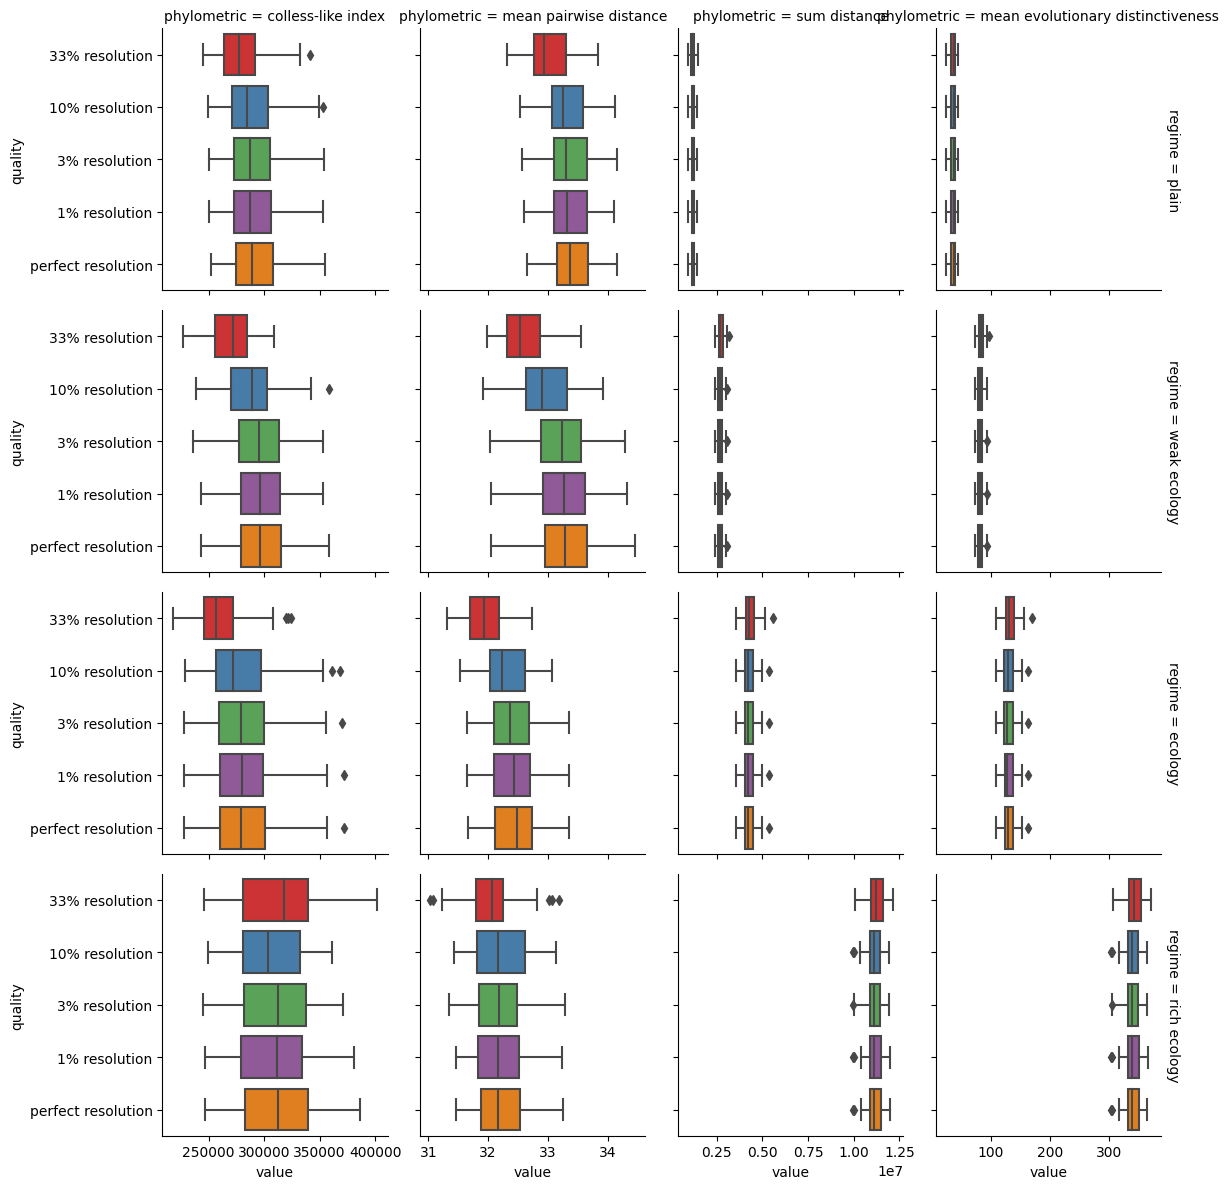

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


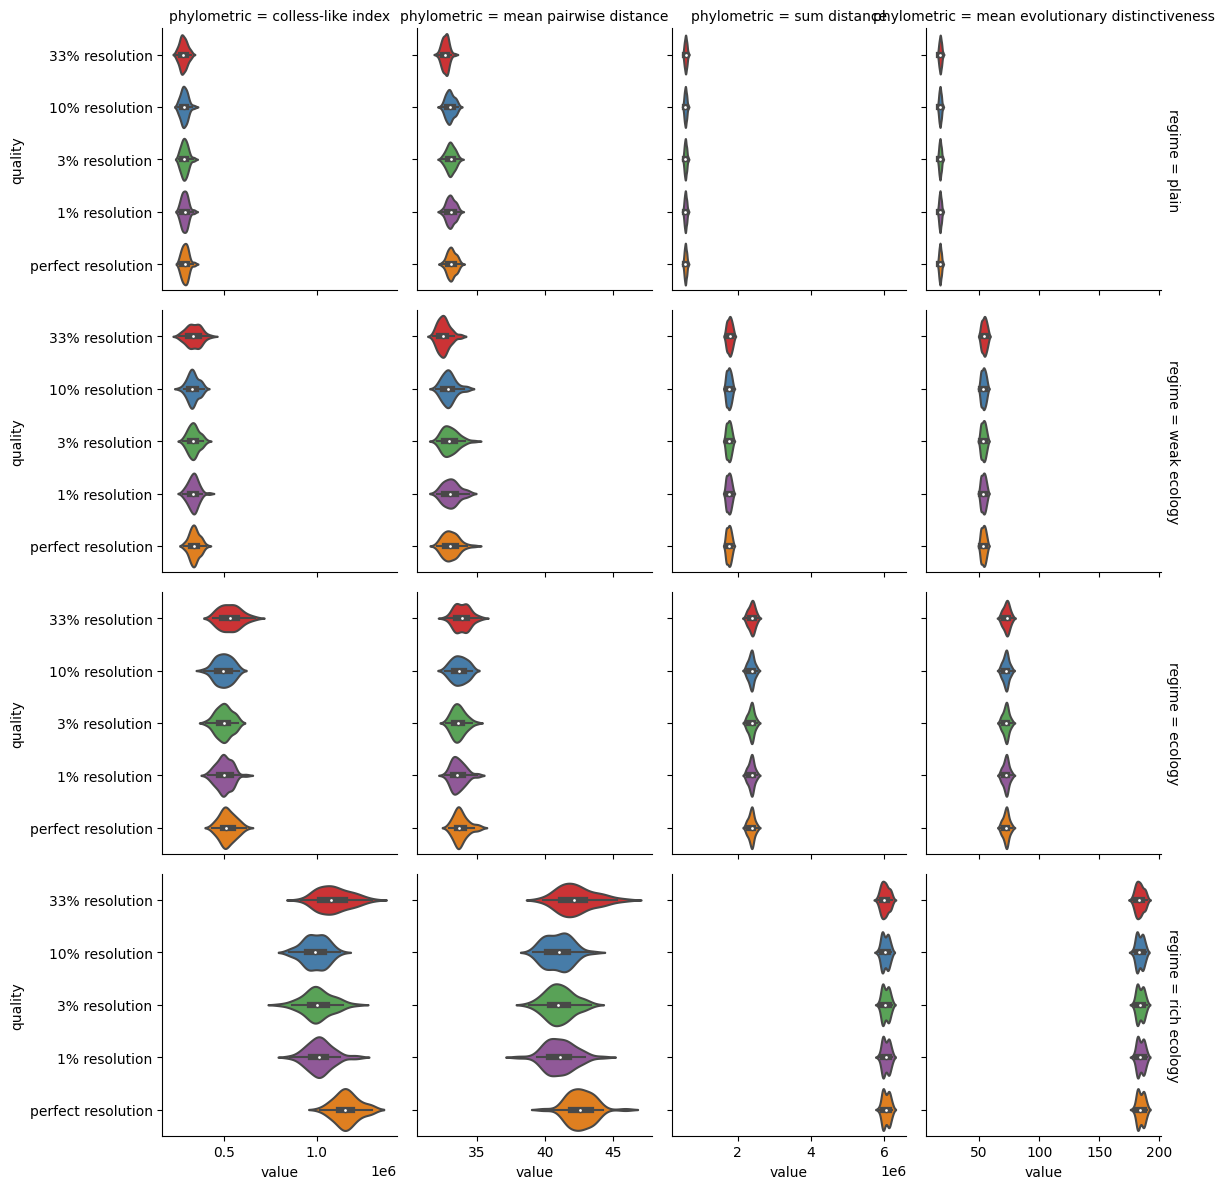

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


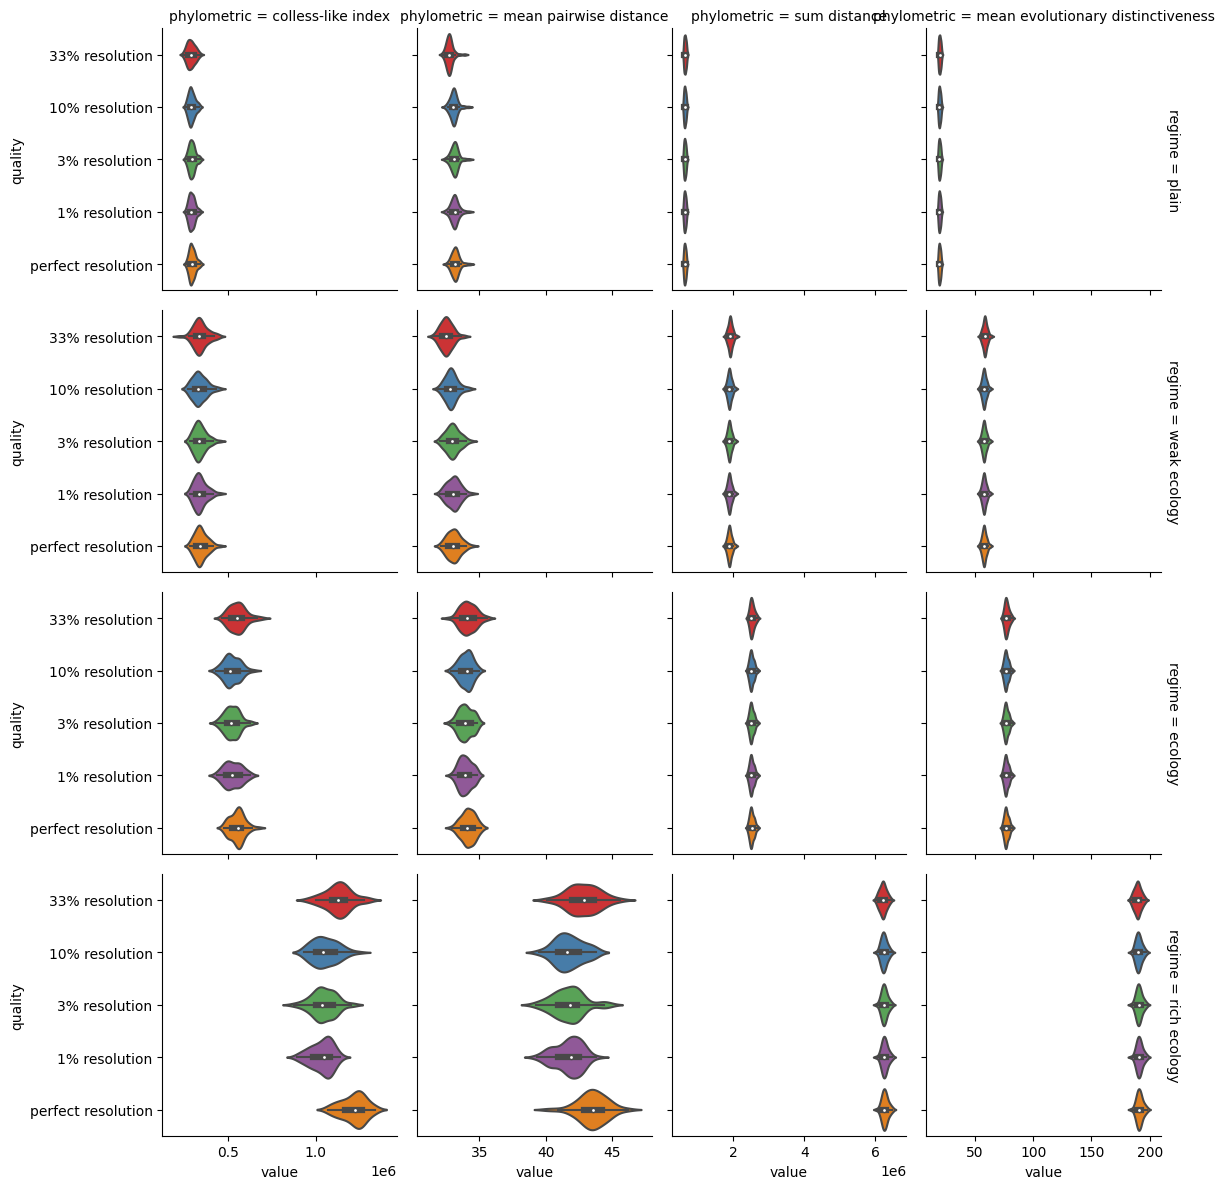

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


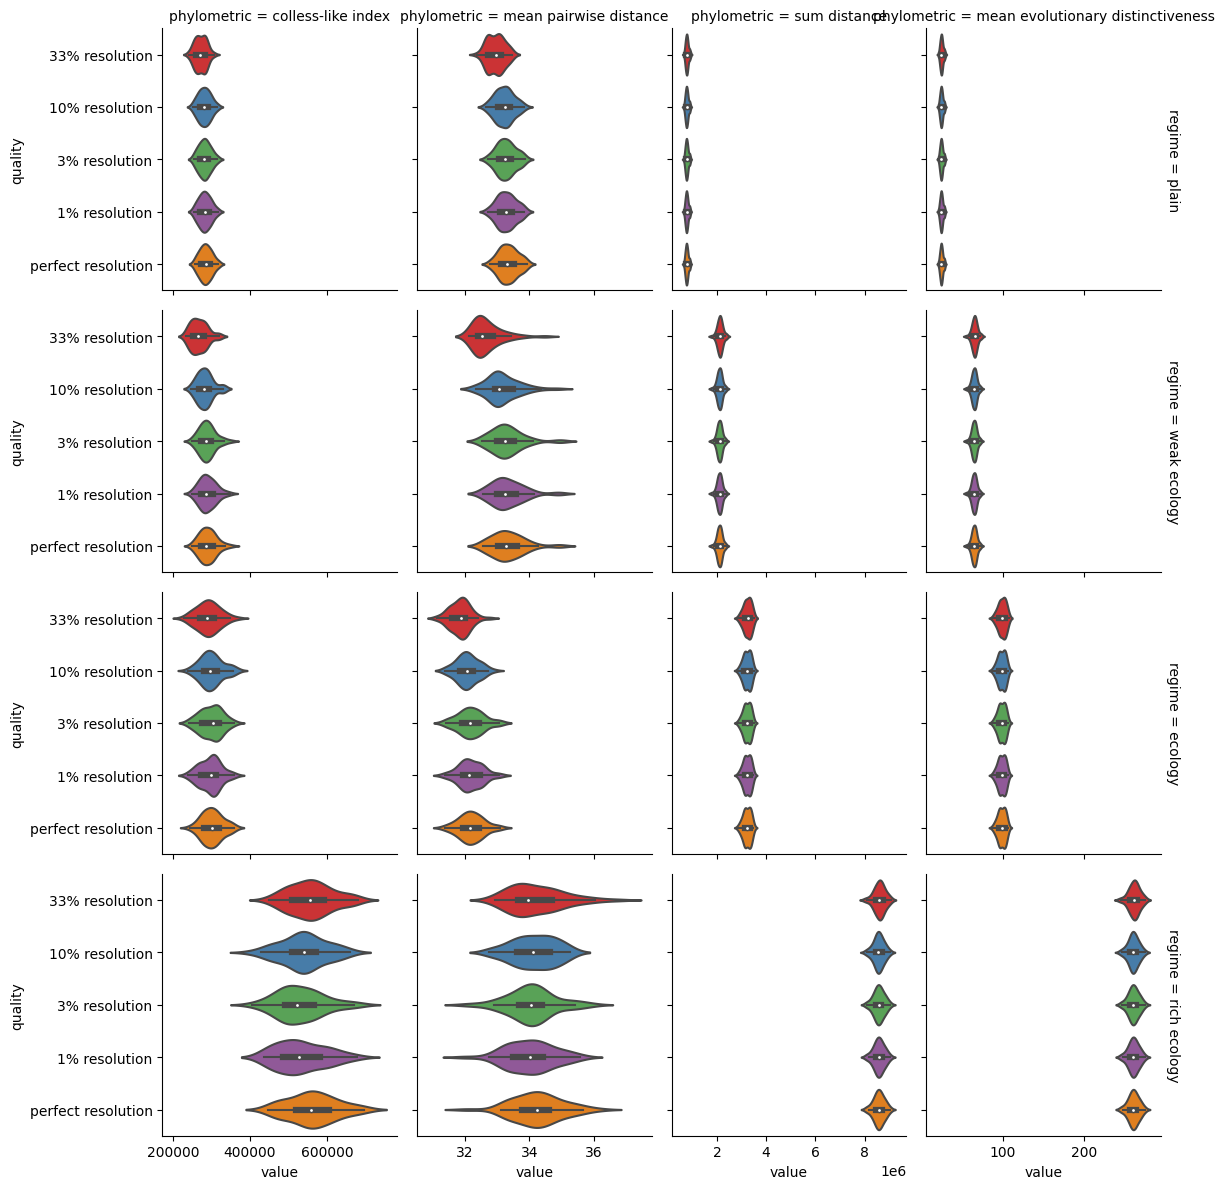

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


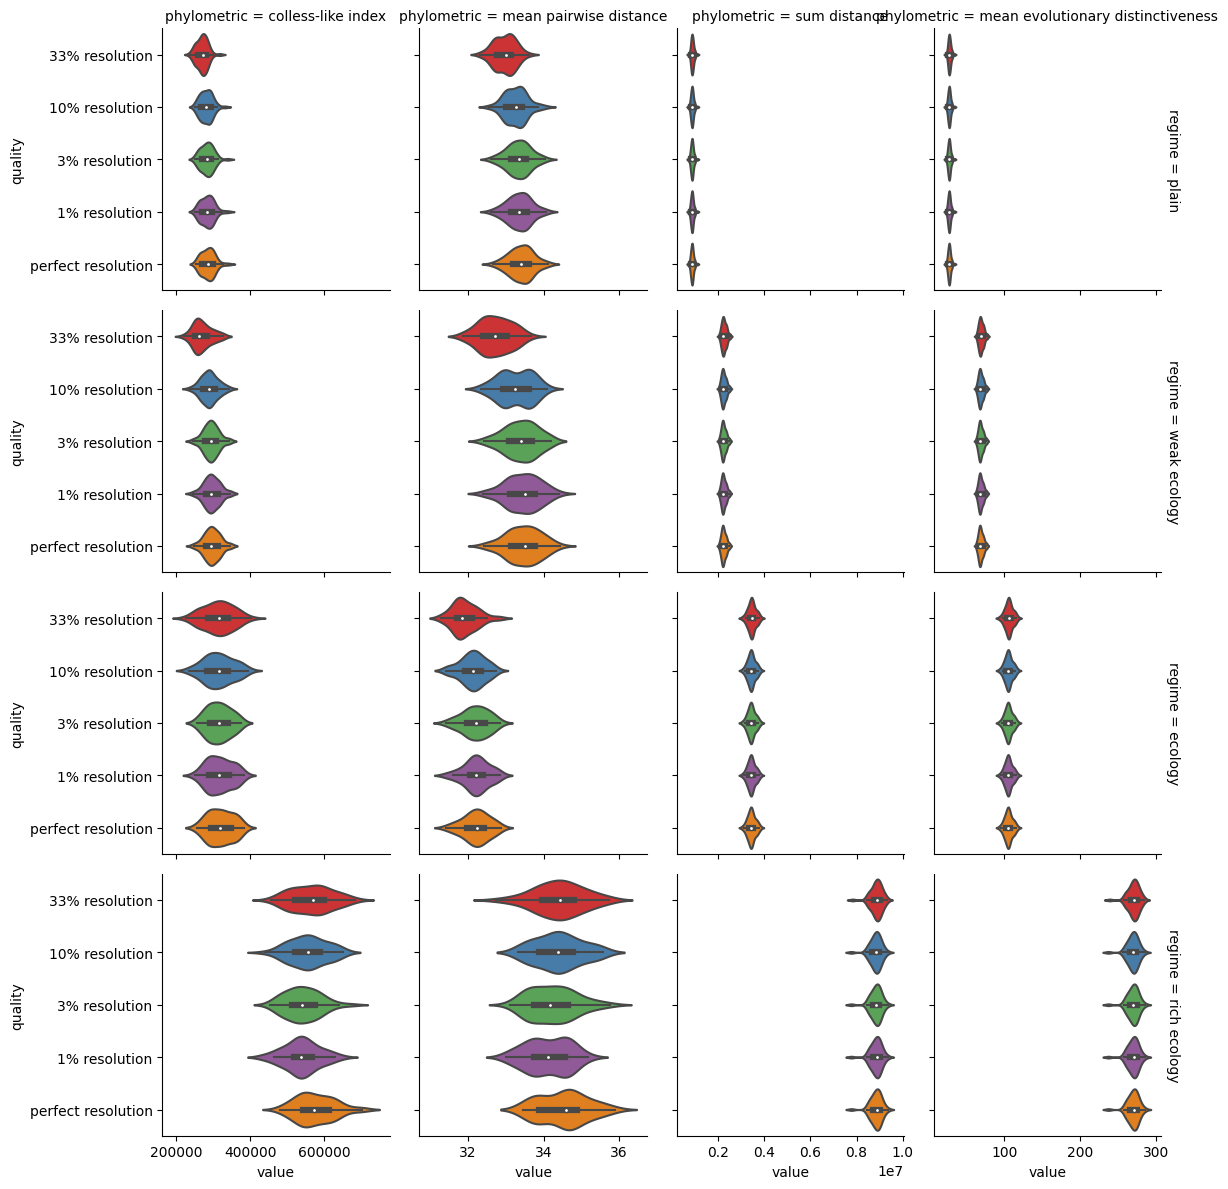

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


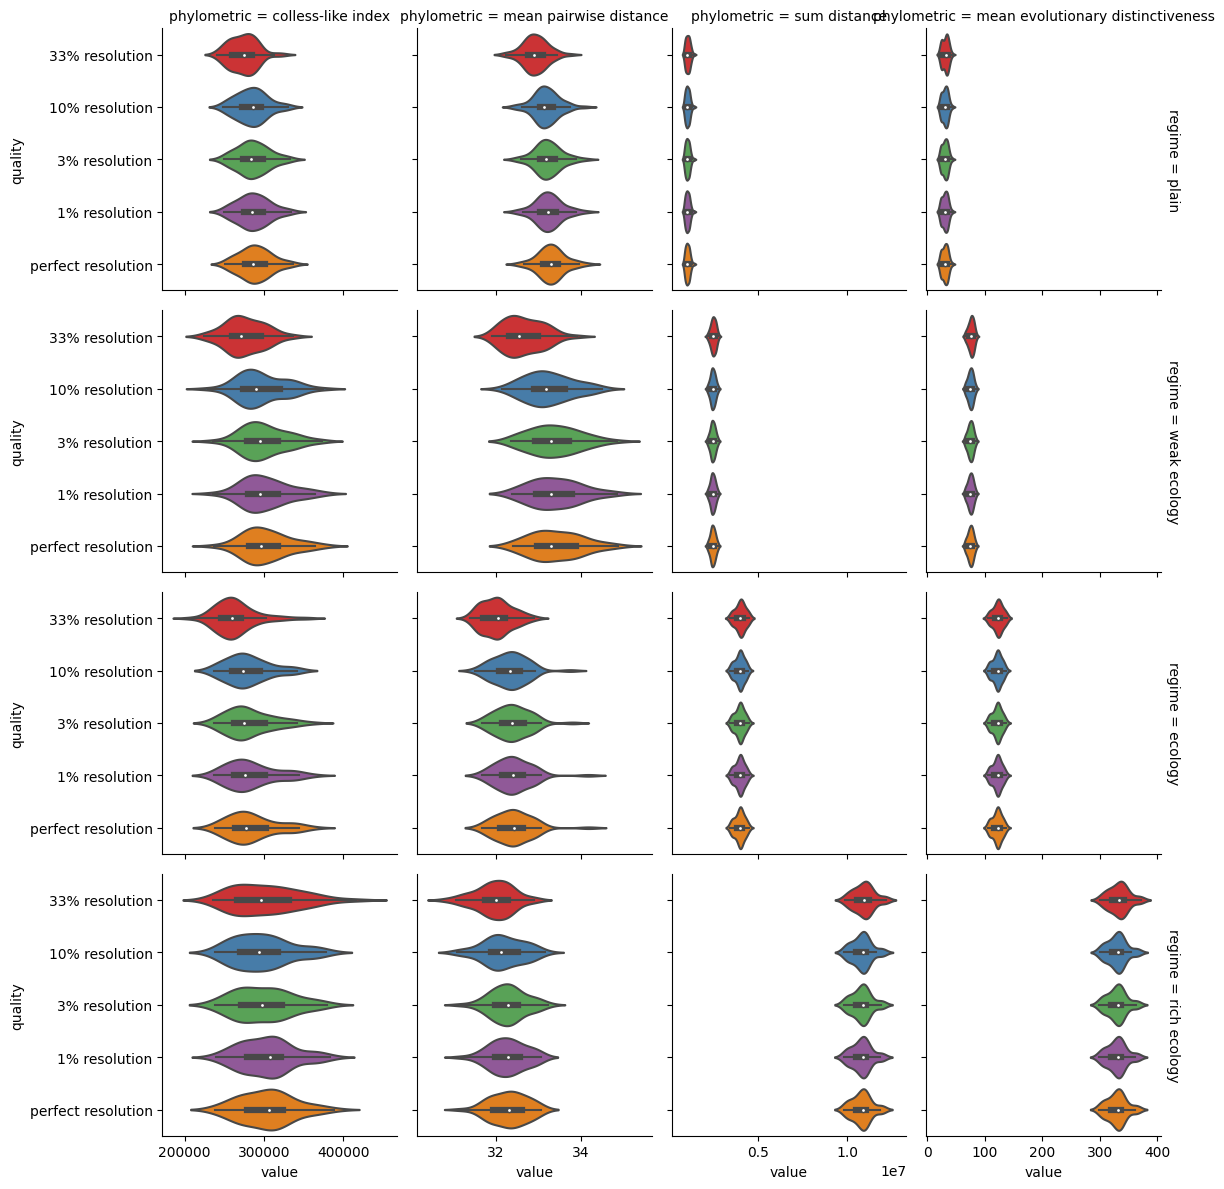

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


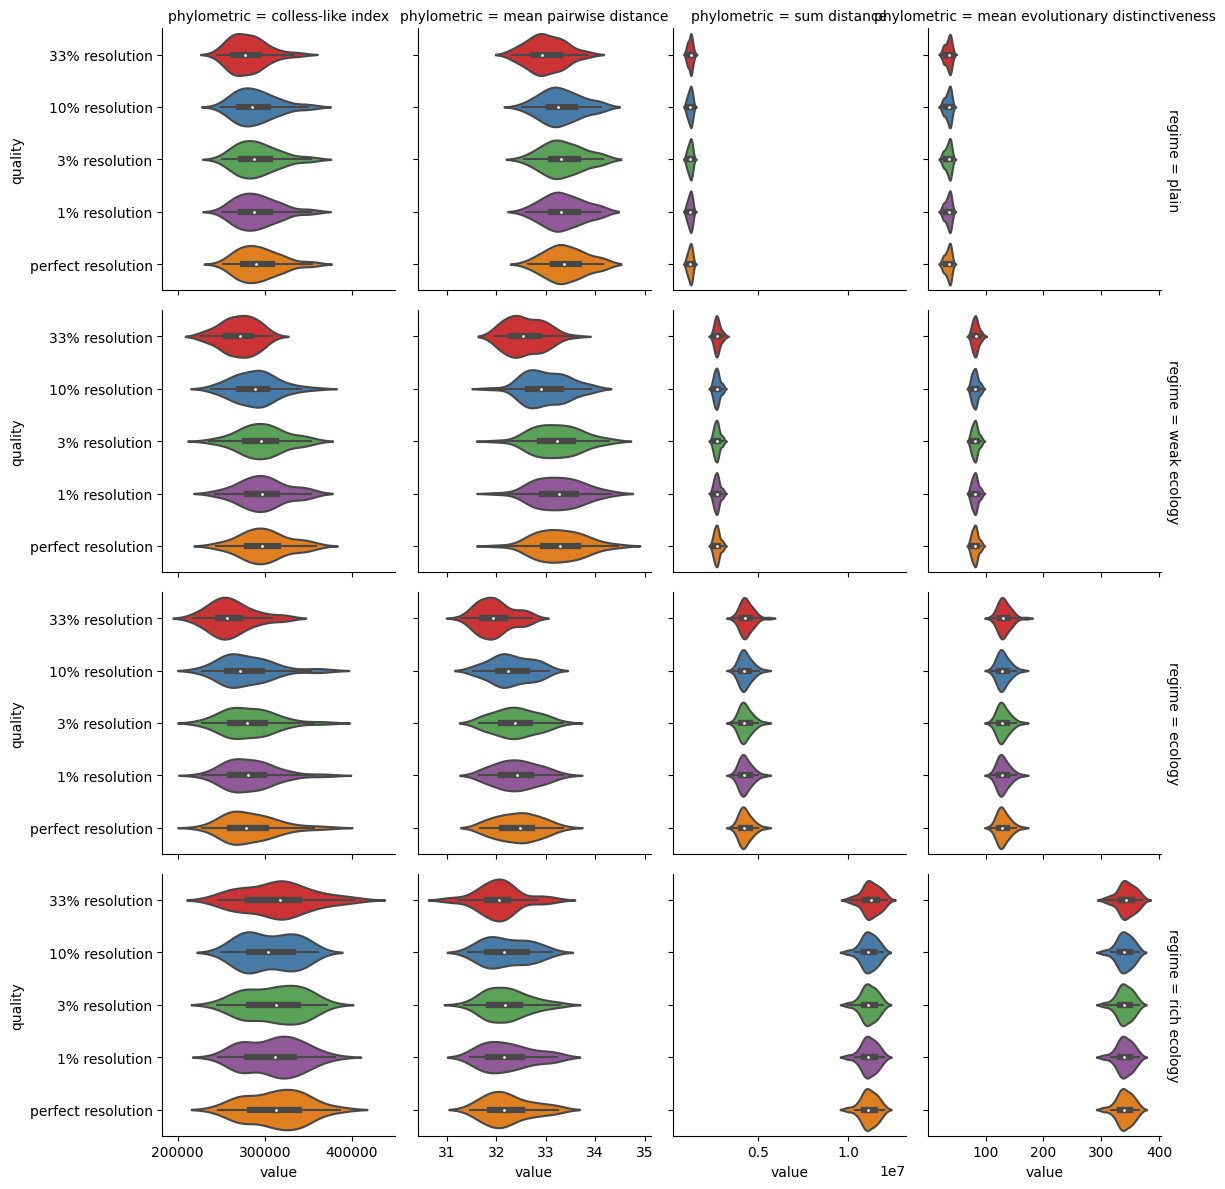

In [25]:
def make_do_plot(plotter):
    def do_plot(data, col, row, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            row=row,
            row_order=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            sharex="col",
            margin_titles=True,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "33% resolution",
                "10% resolution",
                "3% resolution",
                "1% resolution",
                "perfect resolution",
            ],
            palette=sns.color_palette("Set1", 5),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        row="regime",
        x="value",
        y="quality",
        teeplot_outattrs={
            **{
                "nuisance": "spatial-structure",
            },
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
        },
    )


# stats: comparison against perfect


In [26]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        ["regime", *sensitivity_analysis_variables], as_index=False
    ):
        for quality in group_df["quality"].unique():
            if quality == "perfect resolution":
                continue
            kw_result, n = scipy_stats.wilcoxon(
                *zip(
                    *zip(
                        group_df[group_df["quality"] == "perfect resolution"][
                            phylometric
                        ],
                        group_df[group_df["quality"] == quality][phylometric],
                    )
                ),
            ), min(group_df.groupby(["quality"]).count()["a"])
            records.append(
                {
                    **{"quality": quality, "n": n, "phylometric": phylometric},
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(
                        zip(["regime", *sensitivity_analysis_variables], group)
                    ),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime", "phylometric"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-resolutions-allpairs-wilcox-spatial-nuisance+ext=.csv",
        index=False,
    )


quality   n                        phylometric  statistic  \
0    33% resolution  50                 colless-like index      523.0   
1    10% resolution  50                 colless-like index      401.0   
2     1% resolution  50                 colless-like index      434.0   
3     3% resolution  50                 colless-like index      438.0   
4    33% resolution  50  mean evolutionary distinctiveness      514.0   
5    10% resolution  50  mean evolutionary distinctiveness      606.0   
6     1% resolution  50  mean evolutionary distinctiveness      631.0   
7     3% resolution  50  mean evolutionary distinctiveness      579.0   
8    33% resolution  50             mean pairwise distance      560.0   
9    10% resolution  50             mean pairwise distance      517.0   
10    1% resolution  50             mean pairwise distance      466.0   
11    3% resolution  50             mean pairwise distance      460.0   
12   33% resolution  50                       sum distance      514.0   
13   10% resolution  50                       sum distance      606.0   
14    1% resolution  50                       sum distance      631.0   
15    3% resolution  50                       sum distance      579.5   
16   33% resolution  50                 colless-like index      420.0   
17   10% resolution  50                 colless-like index      499.0   
18    3% resolution  50                 colless-like index      513.0   
19    1% resolution  50                 colless-like index      626.0   
20   33% resolution  50  mean evolutionary distinctiveness      556.0   
21   10% resolution  50  mean evolutionary distinctiveness      634.0   
22    3% resolution  50  mean evolutionary distinctiveness      607.0   
23    1% resolution  50  mean evolutionary distinctiveness      613.0   
24   33% resolution  50             mean pairwise distance       68.0   
25   10% resolution  50             mean pairwise distance      438.0   
26    3% resolution  50             mean pairwise distance      531.0   
27    1% resolution  50             mean pairwise distance      579.0   
28   33% resolution  50                       sum distance      556.0   
29   10% resolution  50                       sum distance      634.0   
30    3% resolution  50                       sum distance      607.0   
31    1% resolution  50                       sum distance      613.0   
32   10% resolution  50                 colless-like index        5.0   
33    1% resolution  50                 colless-like index       31.0   
34   33% resolution  50                 colless-like index      224.0   
35    3% resolution  50                 colless-like index        5.0   
36   10% resolution  50  mean evolutionary distinctiveness      511.0   
37    1% resolution  50  mean evolutionary distinctiveness      632.0   
38   33% resolution  50  mean evolutionary distinctiveness      486.0   
39    3% resolution  50  mean evolutionary distinctiveness      563.0   
40   10% resolution  50             mean pairwise distance       73.0   
41    1% resolution  50             mean pairwise distance      105.0   
42   33% resolution  50             mean pairwise distance      481.0   
43    3% resolution  50             mean pairwise distance       58.0   
44   10% resolution  50                       sum distance      511.0   
45    1% resolution  50                       sum distance      632.0   
46   33% resolution  50                       sum distance      486.0   
47    3% resolution  50                       sum distance      563.0   
48    3% resolution  50                 colless-like index      544.0   
49    1% resolution  50                 colless-like index      520.0   
50   10% resolution  50                 colless-like index      489.0   
51   33% resolution  50                 colless-like index      564.0   
52    3% resolution  50  mean evolutionary distinctiveness      612.0   
53    1% resolution  50  mean evolutionary distinctiveness      613.0 

# error signficance heatmap


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


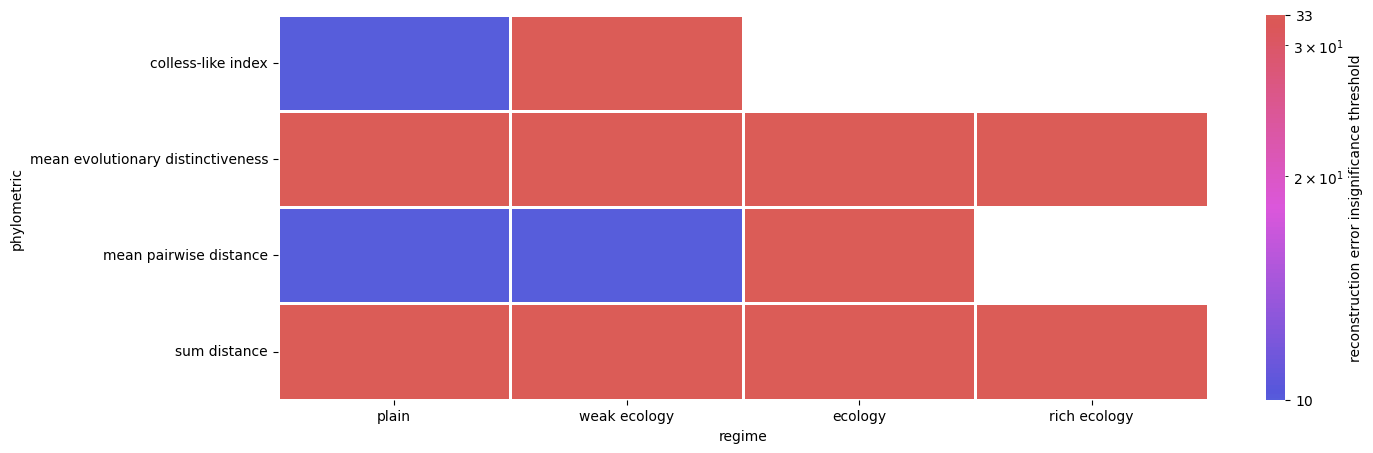

teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


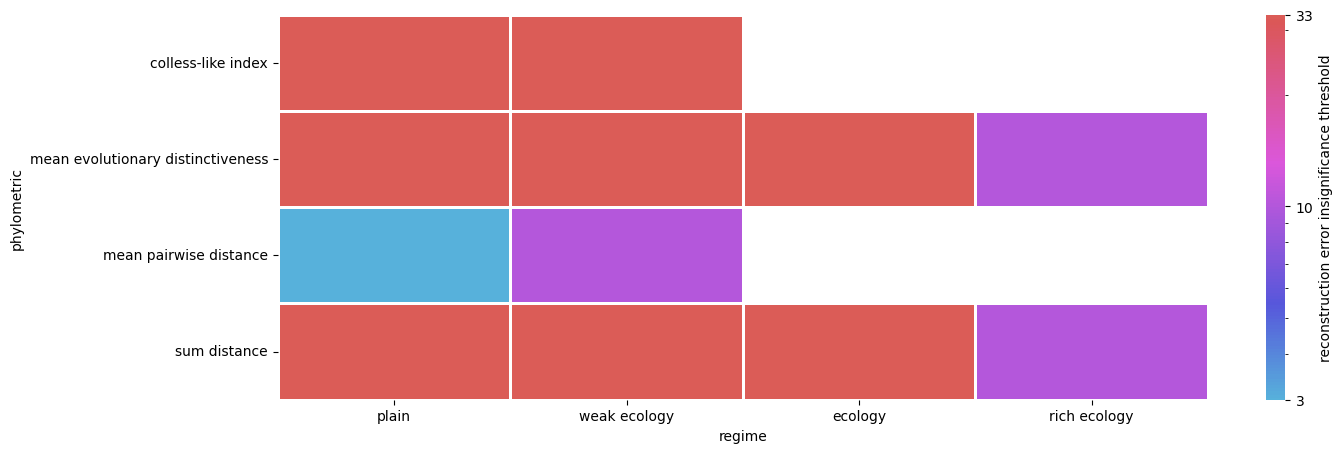

teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


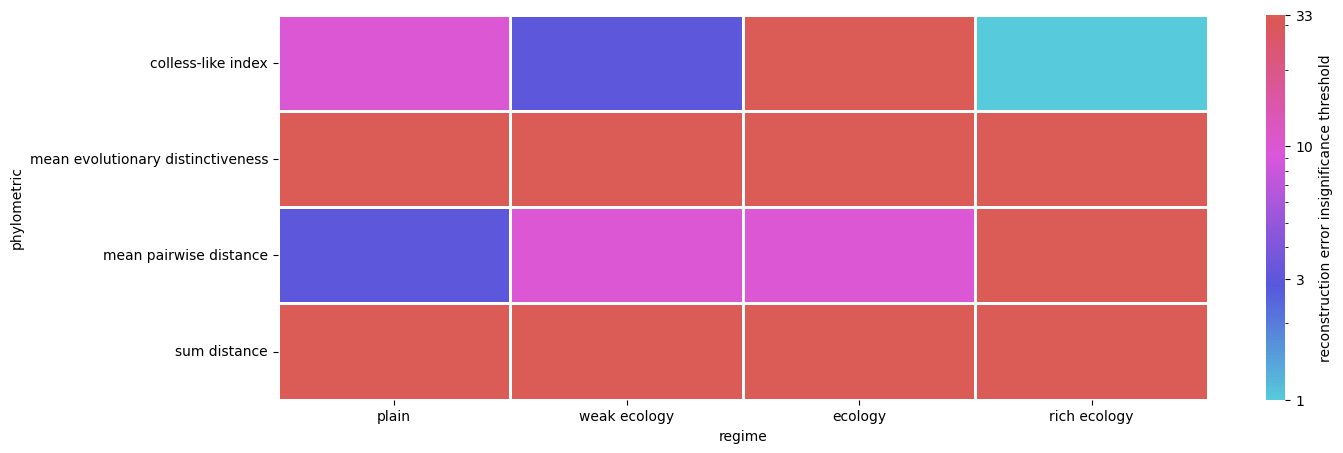

teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


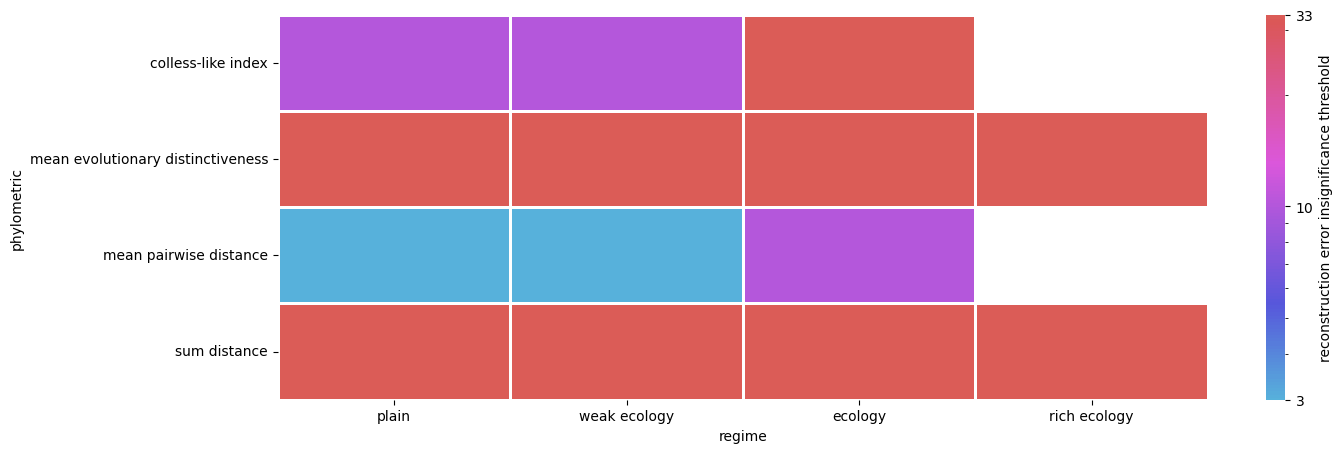

teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


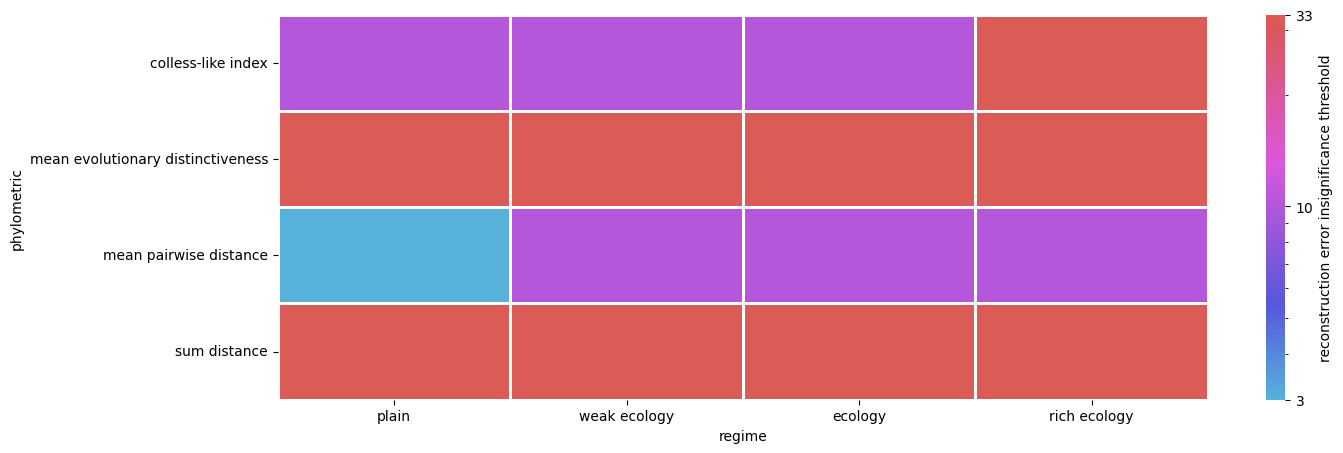

teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


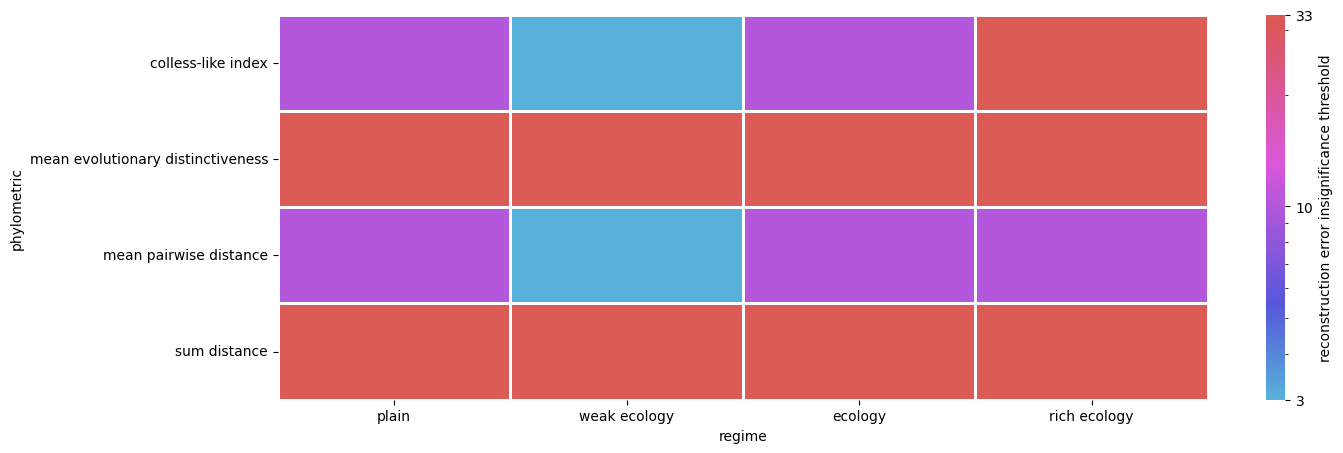

regime                        phylometric  quality threshold  epoch  \
0        ecology                 colless-like index                 10      7   
1        ecology  mean evolutionary distinctiveness                 33      7   
2        ecology             mean pairwise distance                 10      7   
3        ecology                       sum distance                 33      7   
4          plain                 colless-like index                 10      7   
5          plain  mean evolutionary distinctiveness                 33      7   
6          plain             mean pairwise distance                 10      7   
7          plain                       sum distance                 33      7   
8   rich ecology                 colless-like index                 33      7   
9   rich ecology  mean evolutionary distinctiveness                 33      7   
10  rich ecology             mean pairwise distance                 10      7   
11  rich ecology                       sum distance                 33      7   
12  weak ecology                 colless-like index                  3      7   
13  weak ecology  mean evolutionary distinctiveness                 33      7   
14  weak ecology             mean pairwise distance                  3      7   
15  weak ecology                       sum distance                 33      7   

                    mut_distn  
0   np.random.standard_normal  
1   np.random.standard_normal  
2   np.random.standard_normal  
3   np.random.standard_normal  
4   np.random.standard_normal  
5   np.random.standard_normal  
6   np.random.standard_normal  
7   np.random.standard_normal  
8   np.random.standard_normal  
9   np.random.standard_normal  
10  np.random.standard_normal  
11  np.random.standard_normal  
12  np.random.standard_normal  
13  np.random.standard_normal  
14  np.random.standard_normal  
15  np.random.standard_normal

In [27]:
for group, group_df in out_df.groupby(
    sensitivity_analysis_variables, as_index=False
):
    group_df["quality threshold"] = group_df["quality"]
    group_df.loc[group_df["p"] > 0.05, "quality threshold"] = ""
    summarized_df = (
        group_df.groupby(["regime", "phylometric"])
        .agg(
            {
                "quality threshold": lambda subgroup: (
                    np.nan
                    if "1% resolution" in set(subgroup)
                    else 1
                    if "3% resolution" in set(subgroup)
                    else 3
                    if "10% resolution" in set(subgroup)
                    else 10
                    if "33% resolution" in set(subgroup)
                    else 33
                ),
                "epoch": lambda subgroup: ip.pophomogeneous(subgroup),
                "mut_distn": lambda subgroup: ip.pophomogeneous(subgroup),
            }
        )
        .reset_index()
    )

    matrix = summarized_df.pivot(
        index="phylometric",
        columns="regime",
        values="quality threshold",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    fig, ax = plt.subplots(figsize=(15, 5))
    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    tp.tee(
        sns.heatmap,
        matrix,
        linewidths=2,
        norm=mpl.colors.LogNorm(),
        cmap=sns.color_palette("hls", as_cmap=True),
        center=0,
        cbar_kws={
            "label": "reconstruction error insignificance threshold",
            "ticks": [1, 3, 10, 33],
            "format": formatter,
        },
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "nuisance": "spatial-structure",
                "hue": "quality-threshold",
                "x": "regime",
                "y": "phylometric",
            },
        },
    )

summarized_df
